# Temporal Convolutional Network

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/Pump Data/

/content/gdrive/My Drive/Pump Data


In [3]:
!nvidia-smi

Sat Nov 27 19:28:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!ls

allpumps_nbeats.pth.tar       __pycache__
allpumps_tcn_v1.pth.tar       tcn_valid_results.csv
allpumps_transformer.pth.tar  test_results.csv
data			      transformers_valid_results.csv
nbeats_valid_results.csv      utils.py
pump1.gz


In [ ]:
!pip install matplotlib==3.1.3
!pip install darts

In [5]:
EPOCH = 100


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta, TCNModel
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf, plot_hist
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 12               # forecast periods
FC_STRIDE = 10
FC_START = '2019-07-25 00:00:00'   # period at which to split training and validation dataset
DROP = 0.1
LEARN = 0.001

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

In [9]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper


In [10]:
data_address = 'data'
training = pd.read_csv(data_address +'/cfp_dataset_v1.csv', index_col=False)
training.drop(['Unnamed: 0', 'MIDUPT1138P2300058', 'SHORTUPT1138P2300058', 'LONGUPT1138P2300058', 'DMIDT1138P2300058',  'DLONGT1138P2300058', 'UNIXDT', 'UUID'], axis=1, inplace=True)

In [11]:
training.columns

Index(['WELL_ID', 'DT', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399',
       'DSHORTT1138P2300058'],
      dtype='object')

In [12]:
only_1_bad = training[training['WELL_ID'] == 226003316].copy()


In [13]:
only_1_bad.DT

9990     2019-07-31 23:55:00
9991     2019-07-31 23:50:00
9992     2019-07-31 23:45:00
9993     2019-07-31 23:40:00
9994     2019-07-31 23:35:00
                ...         
19972    2019-06-27 07:00:00
19973    2019-06-27 06:55:00
19974    2019-06-27 06:50:00
19975    2019-06-27 06:45:00
19976    2019-06-27 06:40:00
Name: DT, Length: 9987, dtype: object

## подготовим данные для всех насосов

In [14]:
from sklearn.preprocessing import LabelBinarizer

pump_encoder = LabelBinarizer()
transformed = pump_encoder.fit_transform(training.WELL_ID)
ohe_df = pd.DataFrame(transformed)
ohe_df.columns = pump_encoder.classes_
ohe_df.columns = ohe_df.columns.astype(str)

training_oh = pd.concat([training, ohe_df], axis=1).drop(['WELL_ID'], axis=1)
training_oh.columns = training_oh.columns.astype(str)

training_oh

DT  T1138P6000096  ...  226003316  226003330
0       2019-07-31 23:55:00            300  ...          0          1
1       2019-07-31 23:50:00              0  ...          0          1
2       2019-07-31 23:45:00              0  ...          0          1
3       2019-07-31 23:40:00              0  ...          0          1
4       2019-07-31 23:35:00              0  ...          0          1
...                     ...            ...  ...        ...        ...
160257  2019-06-27 07:00:00              0  ...          0          0
160258  2019-06-27 06:55:00              0  ...          0          0
160259  2019-06-27 06:50:00              0  ...          0          0
160260  2019-06-27 06:45:00              0  ...          0          0
160261  2019-06-27 06:40:00              0  ...          0          0

[160262 rows x 35 columns]

реализовать нарезку на train-test


In [15]:
def get_pump_names(df):
  """
  вытаскиваем set из колонок по df, который подали
  """
  values = df.columns
  return set(values)


def split_df_by_pumps(input_df, ohe_df):
  """
  input_df: дф, в котором есть колонки onehot с насовами
  ohe_df: дф onehot для насосов
  выдает 17 штук train set
  """

  pump_ids = get_pump_names(ohe_df)
  df_list = list()

  for pump in pump_ids:
    df_list.append(input_df[input_df[pump] == 1])

  return df_list



реализовать нарезку на файлы по названию насосов

find when to split?

In [16]:
only_1_bad['DT'] = pd.to_datetime(only_1_bad['DT'] )

print(only_1_bad.DT.min()-
      only_1_bad.DT.max())

only_1_bad.DT.min() + (only_1_bad.DT.max() - only_1_bad.DT.min()) * 0.8

-35 days +06:45:00


Timestamp('2019-07-25 01:16:00')

In [17]:
series = TimeSeries.from_dataframe(only_1_bad, 'DT', fill_missing_dates=True, freq=None)


In [18]:
scaler = Scaler()
ts = scaler.fit_transform(series)  # scale the whole time series not caring about train/val split...
filler = MissingValuesFiller()
ts = filler.transform(ts, method='quadratic')
target = ts['DSHORTT1138P2300058']
# Create training and validation sets:
train_target, val_target = target.split_after(pd.Timestamp(FC_START))

covariates = ts[['WELL_ID', 'T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
       'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
       'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
       'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
       'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399']]

train_cov, val_cov = covariates.split_after(pd.Timestamp(FC_START))
train_1cov, val_1cov = covariates['T1138P600050'].split_after(pd.Timestamp(FC_START))

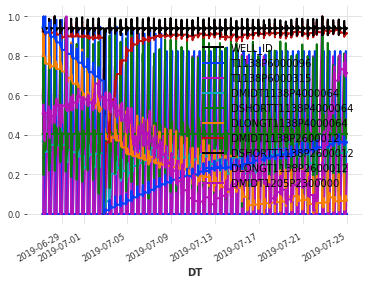

In [19]:
train_cov.plot()

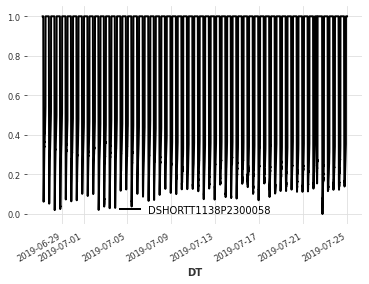

In [20]:
train_target.plot()

In [21]:
train_1cov.freq

<5 * Minutes>

In [22]:
train_1cov.pd_dataframe()

component            T1138P600050
DT                               
2019-06-27 06:40:00           0.0
2019-06-27 06:45:00           0.0
2019-06-27 06:50:00           0.0
2019-06-27 06:55:00           0.0
2019-06-27 07:00:00           0.0
...                           ...
2019-07-24 23:40:00           0.0
2019-07-24 23:45:00           0.0
2019-07-24 23:50:00           0.0
2019-07-24 23:55:00           0.0
2019-07-25 00:00:00           0.0

[7985 rows x 1 columns]

In [23]:
train_target.describe()


component  DSHORTT1138P2300058
count              7985.000000
mean                  0.748431
std                   0.356740
min                   0.000000
25%                   0.322829
50%                   1.000000
75%                   1.000000
max                   1.000000

In [24]:
train_target

<TimeSeries (DataArray) (DT: 7985, component: 1, sample: 1)>
array([[[1.]],

       [[1.]],

       [[1.]],

       ...,

       [[1.]],

       [[1.]],

       [[1.]]])
Coordinates:
  * DT         (DT) datetime64[ns] 2019-06-27T06:40:00 ... 2019-07-25
  * component  (component) object 'DSHORTT1138P2300058'
Dimensions without coordinates: sample

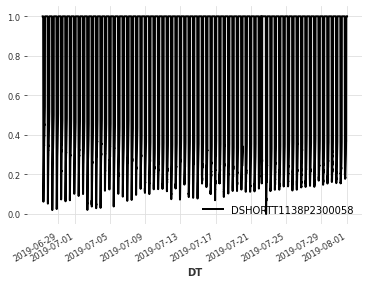

In [25]:
target.plot()

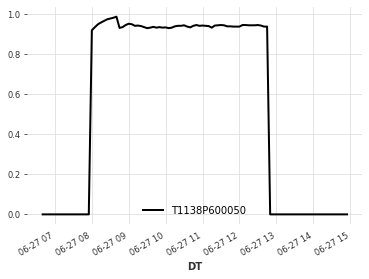

In [26]:
train_1cov[:100].plot()

In [27]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(target, max_lag=1000)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (5*minutes)":f'{periodicity:.1f}', 
    "periodicity (hours)":f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (5*minutes) : 144.0
periodicity (hours) : 12.0


In [28]:
import statsmodels.api as sm

<AxesSubplot:xlabel='DT'>

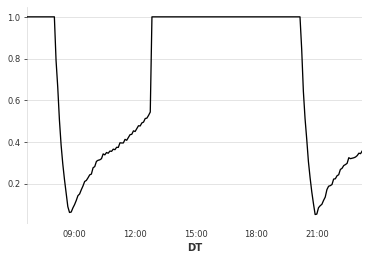

In [29]:
target.pd_dataframe().DSHORTT1138P2300058[:200].plot()

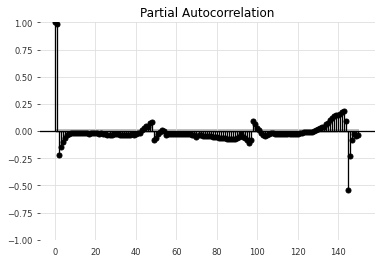

In [30]:
sm.graphics.tsa.plot_pacf(target.pd_dataframe().DSHORTT1138P2300058, lags=150)
plt.show()

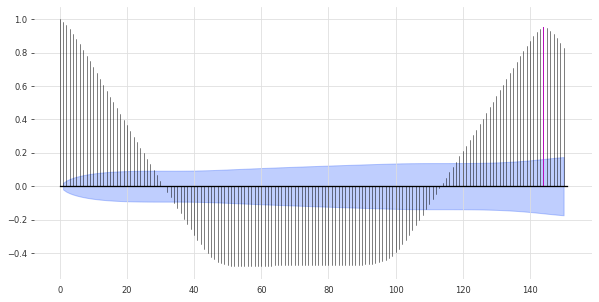

In [31]:
plot_acf(target, periodicity, max_lag=150)


In [32]:
target.describe()

component  DSHORTT1138P2300058
count             10000.000000
mean                  0.750620
std                   0.355972
min                   0.000000
25%                   0.319466
50%                   1.000000
75%                   1.000000
max                   1.000000

In [33]:
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape, mae


# lets do a simple one

In [34]:
one_var = covariates['T1205P2300000'].copy()

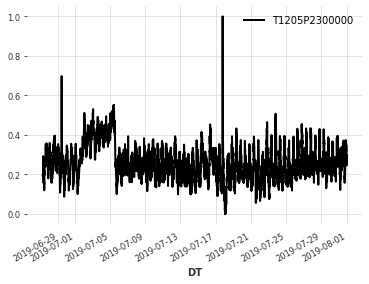

In [35]:
one_var.plot()

In [36]:
train_cov1, val_cov1 = one_var.split_after(pd.Timestamp('2019-07-25 00:00:00'))

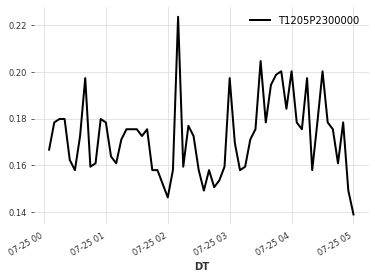

In [37]:
val_cov1[:60].plot()

In [38]:
val_cov1.time_index

DatetimeIndex(['2019-07-25 00:05:00', '2019-07-25 00:10:00',
               '2019-07-25 00:15:00', '2019-07-25 00:20:00',
               '2019-07-25 00:25:00', '2019-07-25 00:30:00',
               '2019-07-25 00:35:00', '2019-07-25 00:40:00',
               '2019-07-25 00:45:00', '2019-07-25 00:50:00',
               ...
               '2019-07-31 23:10:00', '2019-07-31 23:15:00',
               '2019-07-31 23:20:00', '2019-07-31 23:25:00',
               '2019-07-31 23:30:00', '2019-07-31 23:35:00',
               '2019-07-31 23:40:00', '2019-07-31 23:45:00',
               '2019-07-31 23:50:00', '2019-07-31 23:55:00'],
              dtype='datetime64[ns]', name='DT', length=2015, freq='5T')

In [39]:
model_1var = TCNModel(
    input_chunk_length=24,
    output_chunk_length=2,
    n_epochs=EPOCH,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [40]:
model_1var.fit(series=train_target,
              past_covariates=train_cov1,
              val_series=val_target,
              val_past_covariates=val_cov1,
              verbose=True)

  1%|          | 1/100 [00:04<07:43,  4.68s/it]

 11%|█         | 11/100 [00:43<05:54,  3.99s/it]

 21%|██        | 21/100 [01:21<05:15,  3.99s/it]

 31%|███       | 31/100 [01:59<04:32,  3.95s/it]

 41%|████      | 41/100 [02:37<03:54,  3.98s/it]

 51%|█████     | 51/100 [03:15<03:12,  3.93s/it]

 61%|██████    | 61/100 [03:53<02:34,  3.95s/it]

 71%|███████   | 71/100 [04:30<01:53,  3.91s/it]

 81%|████████  | 81/100 [05:08<01:15,  3.95s/it]

 91%|█████████ | 91/100 [05:46<00:35,  3.94s/it]

100%|██████████| 100/100 [06:20<00:00,  3.80s/it]


In [41]:
backtest_1var = model_1var.historical_forecasts(series=val_target,
                                                past_covariates=val_cov1, start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 1814/1814 [00:12<00:00, 140.25it/s]


In [42]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score


def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


In [43]:
val_target_inters = val_target.slice_intersect(backtest_1var)

MAPE = 0.05%
MAE = 0.02
smape = 0.05%
R2 = 0.95%


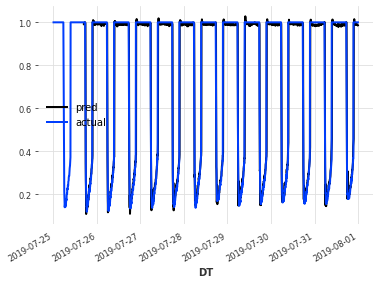

In [44]:
backtest_1var.plot(label='pred')
val_target.plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_target_inters.values(), backtest_1var.values())))
print('MAE = {:.2f}'.format(mae(val_target_inters, backtest_1var)))
print('smape = {:.2f}%'.format(smape(val_target_inters.values(), backtest_1var.values())))
print('R2 = {:.2f}%'.format(r2_score(val_target_inters.values(), backtest_1var.values())))


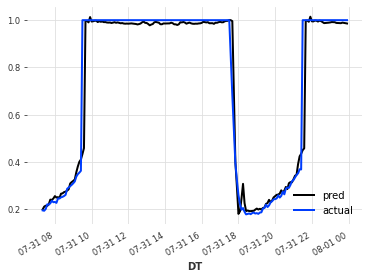

In [45]:
backtest_1var[-200:].plot(label='pred')
val_target[-200:].plot(label='actual')


## do with all covariates for 1 pump

In [46]:
model_1pump = TCNModel(
    input_chunk_length=144,
    output_chunk_length=1,
    n_epochs=EPOCH,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

In [47]:
model_1pump.fit(series=train_target,
              past_covariates=train_cov,
              val_series=val_target,
              val_past_covariates=val_cov,
              verbose=True)

  1%|          | 1/100 [00:05<09:04,  5.50s/it]

 11%|█         | 11/100 [00:52<07:09,  4.82s/it]

 21%|██        | 21/100 [01:38<06:20,  4.82s/it]

 31%|███       | 31/100 [02:25<05:33,  4.83s/it]

 41%|████      | 41/100 [03:12<04:48,  4.89s/it]

 51%|█████     | 51/100 [03:59<03:58,  4.86s/it]

 61%|██████    | 61/100 [04:46<03:09,  4.86s/it]

 71%|███████   | 71/100 [05:33<02:20,  4.85s/it]

 81%|████████  | 81/100 [06:19<01:31,  4.81s/it]

 91%|█████████ | 91/100 [07:06<00:43,  4.82s/it]

100%|██████████| 100/100 [07:47<00:00,  4.68s/it]


In [48]:
backtest_1pump = model_1pump.historical_forecasts(series=val_target,
                                                past_covariates=val_cov, start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 1814/1814 [00:14<00:00, 122.52it/s]


In [49]:
val_1pumptarget_inters = val_target.slice_intersect(backtest_1pump)

MAPE = 0.04%
MAE = 0.02
smape = 0.05%
R2 = 0.99%


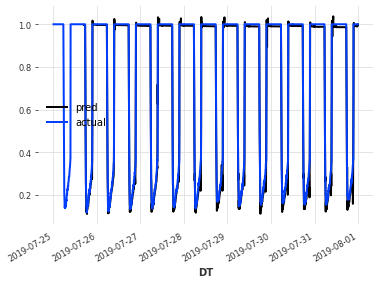

In [50]:
backtest_1pump.plot(label='pred')
val_target.plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_1pumptarget_inters.values(), backtest_1pump.values())))
print('MAE = {:.2f}'.format(mae(val_1pumptarget_inters, backtest_1pump)))
print('smape = {:.2f}%'.format(smape(val_1pumptarget_inters.values(), backtest_1pump.values())))
print('R2 = {:.2f}%'.format(r2_score(val_1pumptarget_inters.values(), backtest_1pump.values())))


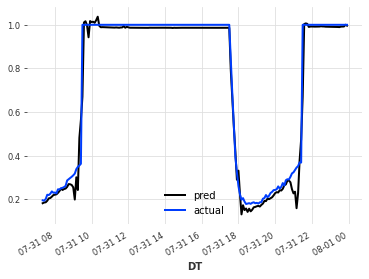

In [51]:
backtest_1pump[-200:].plot(label='pred')
val_target[-200:].plot(label='actual')

## сделаем теперь обучение на множестве временных рядов

In [52]:
all_pumps_df = split_df_by_pumps(training_oh, ohe_df)

In [53]:
all_pumps_df[0].head()

DT  T1138P6000096  ...  226003316  226003330
19977  2019-07-31 23:55:00              0  ...          0          0
19978  2019-07-31 23:50:00              0  ...          0          0
19979  2019-07-31 23:45:00              0  ...          0          0
19980  2019-07-31 23:40:00              0  ...          0          0
19981  2019-07-31 23:35:00              0  ...          0          0

[5 rows x 35 columns]

In [54]:
FC_START

'2019-07-25 00:00:00'

In [55]:
def get_one_pump_train_date(inp_df):
  onehot_series_0 = TimeSeries.from_dataframe(inp_df, 'DT', fill_missing_dates=True, freq='5T')

  scaler = Scaler()
  ts = scaler.fit_transform(onehot_series_0)  # scale the whole time series not caring about train/val split...
  filler = MissingValuesFiller()
  ts = filler.transform(ts, method='linear')
  target = ts['DSHORTT1138P2300058']
  # Create training and validation sets:
  train_target, val_target = target.split_after(pd.Timestamp(FC_START))

  covariates = ts[['T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
        'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
        'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
        'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
        'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399', 
       'DSHORTT1138P2300058', '226000188', '226000198', '226000297',
       '226001846', '226001947', '226002142', '226002148', '226002307',
       '226002416', '226002603', '226002627', '226002861', '226002998',
       '226003074', '226003080', '226003316', '226003330']]

  train_cov, val_cov = covariates.split_after(pd.Timestamp(FC_START))
  print(len(train_cov), len(train_target), len(val_cov), len(val_target))
  return train_cov, train_target, val_cov, val_target

def get_all_pump_training_date(df_all_pumps):
  train_cov_all, train_target_all, val_cov_all, val_target_all = [], [], [], []
  for pump_df in df_all_pumps:
    iter_train, iter_target, iter_val, iter_val_target = get_one_pump_train_date(pump_df)
    train_cov_all.append(iter_train)
    train_target_all.append(iter_target)
    val_cov_all.append(iter_val)
    val_target_all.append(iter_val_target)
  return train_cov_all, train_target_all, val_cov_all, val_target_all


In [56]:
train_cov_v3, train_target_v3, val_cov_v3, val_target_v3= get_all_pump_training_date(all_pumps_df)

7985 7985 2015 2015
7985 7985 2015 2015
1165 1165 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015
7985 7985 2015 2015


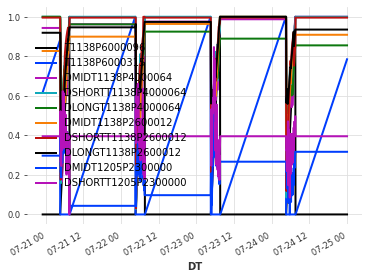

In [57]:
train_cov_v3[2].plot()

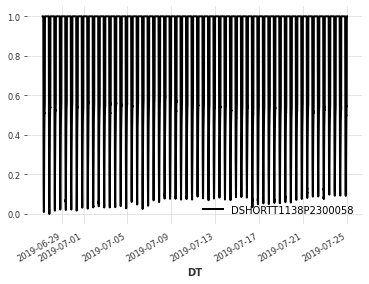

In [58]:
train_target_v3[1].plot()

In [59]:
model_all_pumps = TCNModel(
    input_chunk_length=144,
    output_chunk_length=1,
    n_epochs=EPOCH,
    dropout=0.01,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

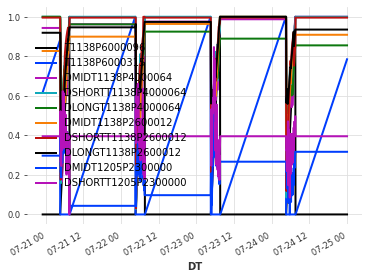

In [60]:
train_cov_v3[2].plot()

In [61]:
model_all_pumps.fit(series=train_target_v3,
              past_covariates=train_cov_v3,
              val_series=val_target_v3,
              val_past_covariates=val_cov_v3,
              verbose=True)

  1%|          | 1/100 [01:33<2:34:08, 93.42s/it]

 11%|█         | 11/100 [15:04<2:04:41, 84.06s/it]

 21%|██        | 21/100 [28:35<1:50:24, 83.85s/it]

 31%|███       | 31/100 [42:05<1:36:13, 83.68s/it]

 41%|████      | 41/100 [55:31<1:22:03, 83.45s/it]

 51%|█████     | 51/100 [1:09:00<1:08:26, 83.80s/it]

 61%|██████    | 61/100 [1:22:36<55:03, 84.70s/it]

 71%|███████   | 71/100 [1:36:15<40:56, 84.72s/it]

 81%|████████  | 81/100 [1:49:57<26:58, 85.20s/it]

 91%|█████████ | 91/100 [2:03:39<12:47, 85.26s/it]

100%|██████████| 100/100 [2:15:38<00:00, 81.38s/it]


In [62]:
model_all_pumps.save_model('allpumps_tcn_v1.pth.tar')

In [63]:
backtest_model_all_pumps = model_all_pumps.historical_forecasts(series=val_target_v3[0],
                                                past_covariates=val_cov_v3[0], start=0.1,
                                            retrain=False,
                                            verbose=True)


100%|██████████| 1814/1814 [00:15<00:00, 119.57it/s]


In [64]:
backtest_v3 = val_target_v3[0]
val_v3pumptarget_inters = backtest_v3.slice_intersect(backtest_model_all_pumps)


MAPE = 0.73%
MAE = 0.01
smape = 0.75%
R2 = 99.31%


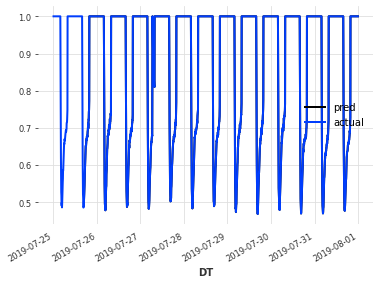

In [65]:
val_v3pumptarget_inters.plot(label='pred')
val_target_v3[0].plot(label='actual')
plt.legend();
print('MAPE = {:.2f}%'.format(mean_absolute_percentage_error(val_v3pumptarget_inters.values(), backtest_model_all_pumps.values())*100))
print('MAE = {:.2f}'.format(mae(val_v3pumptarget_inters, backtest_model_all_pumps)))
print('smape = {:.2f}%'.format(smape(val_v3pumptarget_inters.values(), backtest_model_all_pumps.values())*100))
print('R2 = {:.2f}%'.format(r2_score(val_v3pumptarget_inters.values(), backtest_model_all_pumps.values())*100))


сделаем процедуру для запуска по всем насосам валидации

In [66]:
get_pump_names(ohe_df)


{'226000188',
 '226000198',
 '226000297',
 '226001846',
 '226001947',
 '226002142',
 '226002148',
 '226002307',
 '226002416',
 '226002603',
 '226002627',
 '226002861',
 '226002998',
 '226003074',
 '226003080',
 '226003316',
 '226003330'}

In [67]:
def score_model_darts(model, validation_target, validation_cov, pump_names):
    results = pd.DataFrame(columns=['mape', 'smape', 'mae', 'r2_value'])
    pump_num = 0
    true_values = []
    predict_values = []
    for key in pump_names:
        backtest_model_all_pumps_iter = model_all_pumps.historical_forecasts(
            series=validation_target[pump_num],
            past_covariates=validation_cov[pump_num],
            start=0.1,
            retrain=False,
            verbose=True)

        backtest_v3 = validation_target[pump_num]
        val_v3pumptarget_inters = backtest_v3.slice_intersect(backtest_model_all_pumps_iter)

        

        y_true = val_v3pumptarget_inters.values()
        y_pred = backtest_model_all_pumps_iter.values()

        true_values.append(y_true)
        predict_values.append(y_pred)


        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        smape_v = smape(y_true, y_pred)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        r2_value = r2_score(y_true=y_true, y_pred=y_pred)

        this_key_df = pd.DataFrame({'mape': mape, 'smape': smape_v, 'mae': mae, 'r2_value': r2_value}, index=[key])
        results = results.append(this_key_df)

        val_v3pumptarget_inters[-100:].plot(label='actual')
        backtest_model_all_pumps_iter[-100:].plot(label='pred')
        plt.show()
        val_v3pumptarget_inters[:1000].plot(label='actual_first1k')
        backtest_model_all_pumps_iter[:1000].plot(label='pred_first1k')
        plt.show()
        pump_num += 1

    true_values = np.concatenate(true_values)
    predict_values = np.concatenate(predict_values)
    return results, true_values, predict_values


100%|██████████| 1814/1814 [00:15<00:00, 120.63it/s]


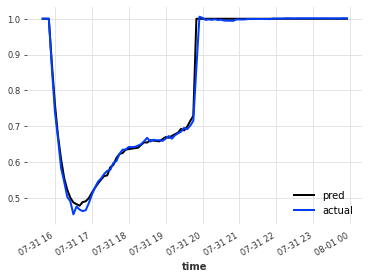

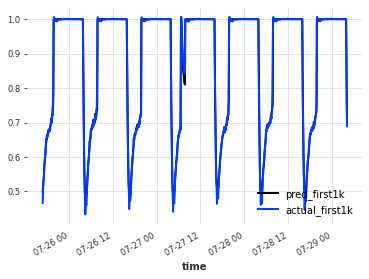

100%|██████████| 1814/1814 [00:15<00:00, 120.52it/s]


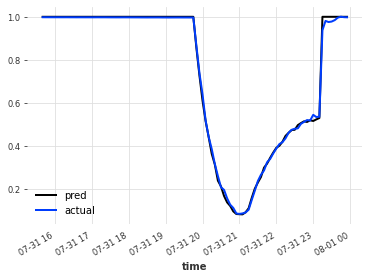

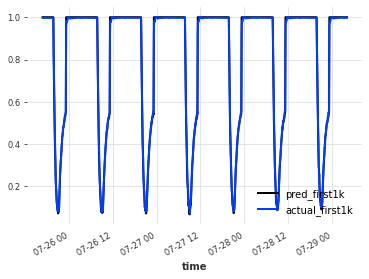

100%|██████████| 1814/1814 [00:15<00:00, 119.94it/s]


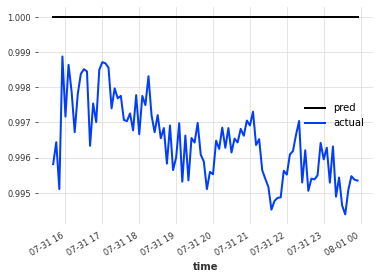

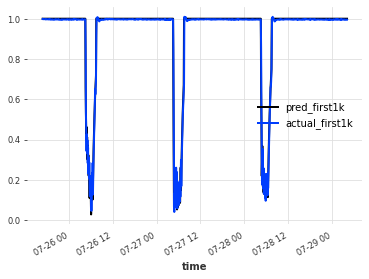

100%|██████████| 1814/1814 [00:15<00:00, 119.66it/s]


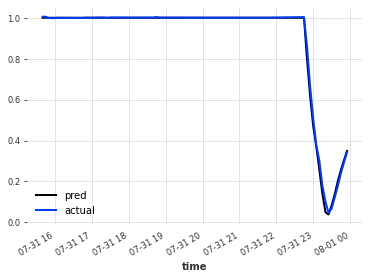

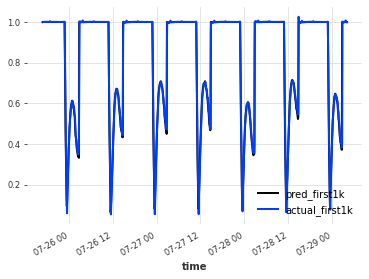

100%|██████████| 1814/1814 [00:15<00:00, 117.96it/s]


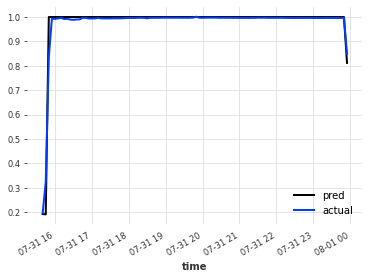

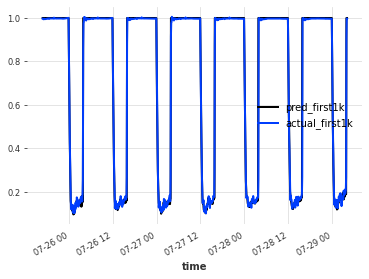

100%|██████████| 1814/1814 [00:15<00:00, 117.98it/s]


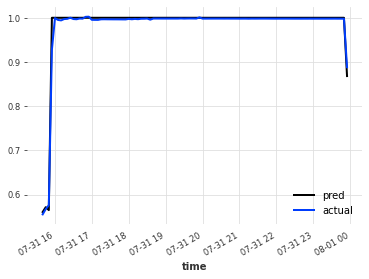

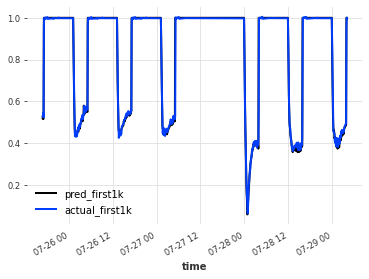

100%|██████████| 1814/1814 [00:15<00:00, 117.26it/s]


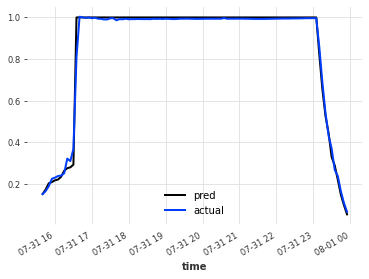

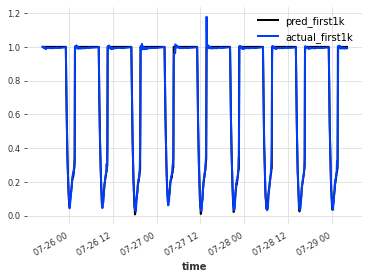

100%|██████████| 1814/1814 [00:15<00:00, 116.30it/s]


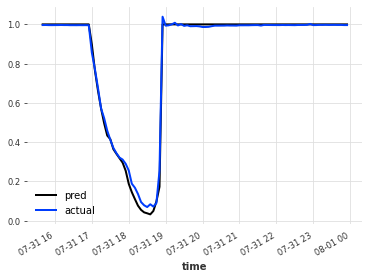

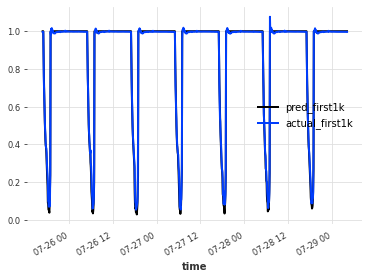

100%|██████████| 1814/1814 [00:15<00:00, 116.43it/s]


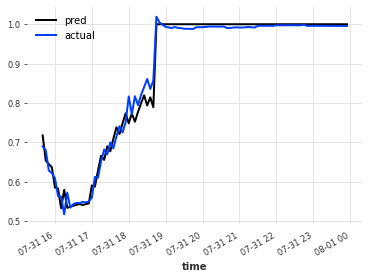

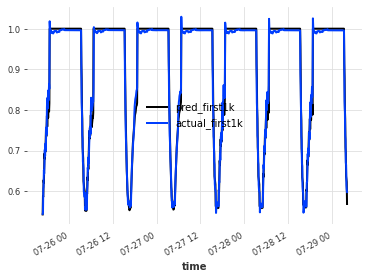

100%|██████████| 1814/1814 [00:15<00:00, 116.06it/s]


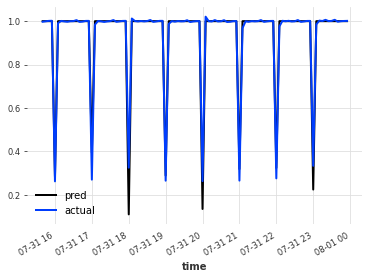

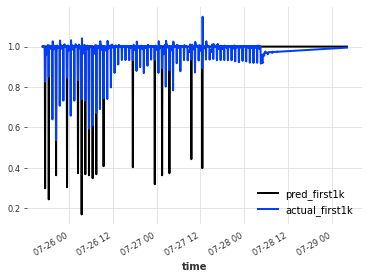

100%|██████████| 1814/1814 [00:15<00:00, 115.32it/s]


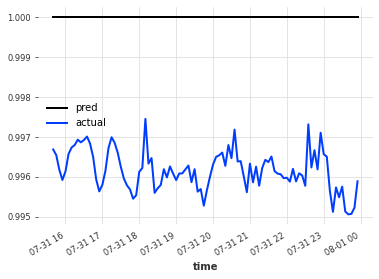

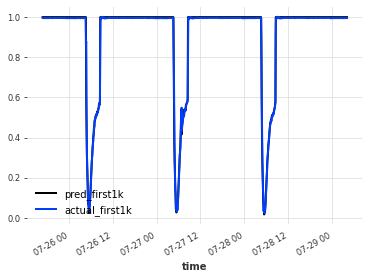

100%|██████████| 1814/1814 [00:15<00:00, 115.13it/s]


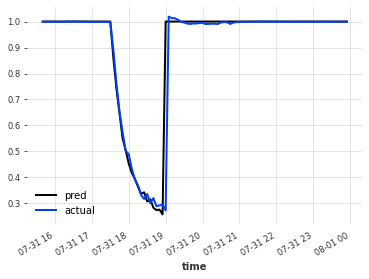

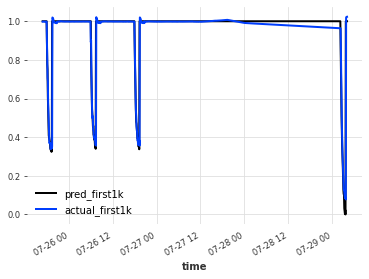

100%|██████████| 1814/1814 [00:15<00:00, 115.55it/s]


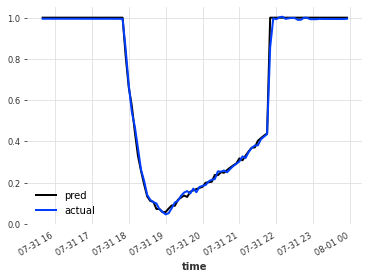

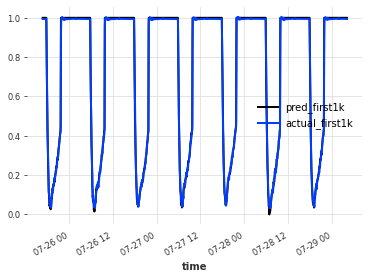

100%|██████████| 1814/1814 [00:15<00:00, 114.78it/s]


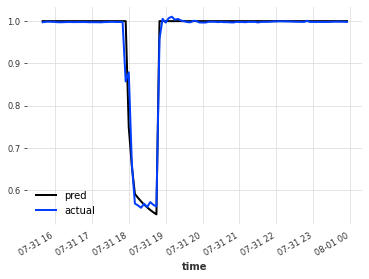

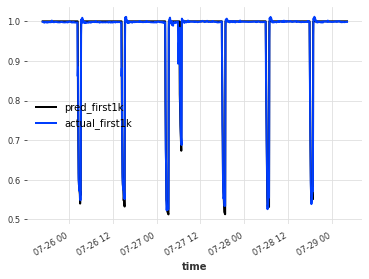

100%|██████████| 1814/1814 [00:15<00:00, 116.35it/s]


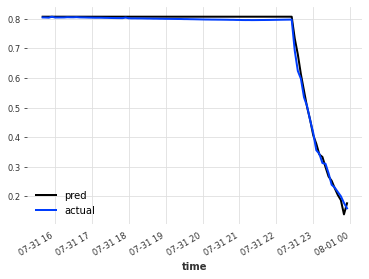

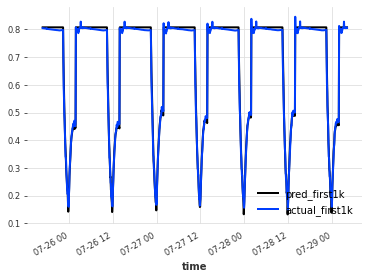

100%|██████████| 1814/1814 [00:15<00:00, 113.88it/s]


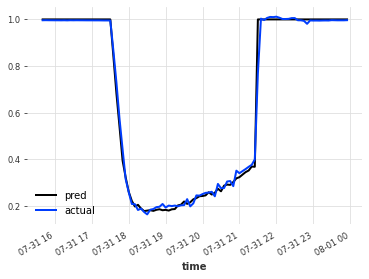

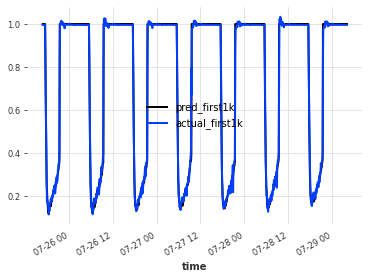

100%|██████████| 1814/1814 [00:15<00:00, 115.27it/s]


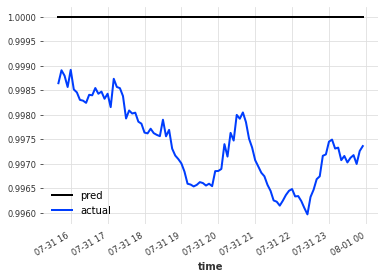

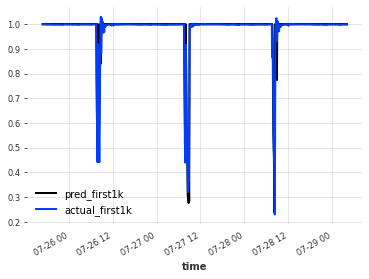

mape     smape       mae  r2_value
226003080  7.338678e-03  0.007478  0.005071  0.993060
226000297  1.753834e-02  0.017050  0.006206  0.998792
226002148  1.557674e+11  0.045813  0.012260  0.980821
226000188  2.209582e-02  0.021571  0.007378  0.989303
226003330  3.007296e-02  0.029563  0.008813  0.992166
226002416  1.079429e-02  0.010826  0.006083  0.993954
226002142  4.149301e-02  0.037616  0.010737  0.993120
226002627  4.330366e-02  0.034307  0.008236  0.993352
226003074  1.272770e-02  0.012673  0.010163  0.988283
226002603  6.960852e+11  0.036952  0.021806  0.786229
226002861  1.769699e-02  0.016277  0.006398  0.996178
226002998  2.151449e+11  0.021664  0.011737  0.920029
226001846  1.181299e+11  0.035436  0.008937  0.998401
226001947  5.616814e-03  0.005636  0.004683  0.972124
226000198  1.645338e-02  0.016234  0.008572  0.996802
226003316  2.797632e-02  0.027795  0.010801  0.994378
226002307  1.588715e-02  0.014194  0.008301  0.911288

In [68]:
results_for_17_test, true_17_test, predict_17 = score_model_darts(model=model_all_pumps, 
                        validation_target=val_target_v3,
                        validation_cov=val_cov_v3,
                        pump_names=get_pump_names(ohe_df))
results_for_17_test

In [69]:
results_for_17_test.to_csv('test_results.csv') 

In [70]:
results_for_17_test.mean()

mape        6.971337e+10
smape       2.300497e-02
mae         9.187114e-03
r2_value    9.704871e-01
dtype: float64

In [71]:
test_tcn = {'test':{'true':true_17_test, 
                      'prediction':predict_17}}

In [72]:
from utils import score_model

In [73]:
test_results = score_model(test_tcn)
test_results

mape     smape       mae  r2_value
test  6.971337e+10  0.023005  0.009187  0.987701

loading validation dataset

In [74]:

def get_one_pump_ext_val(inp_df):
  onehot_series_0 = TimeSeries.from_dataframe(inp_df, 'DT', fill_missing_dates=True, freq='5T')

  scaler = Scaler()
  ts = scaler.fit_transform(onehot_series_0)  # scale the whole time series not caring about train/val split...
  filler = MissingValuesFiller()
  ts = filler.transform(ts, method='linear')
  target = ts['DSHORTT1138P2300058']
  # Create training and validation sets:

  covariates = ts[['T1138P6000096', 'T1138P6000315', 'DMIDT1138P4000064',
        'DSHORTT1138P4000064', 'DLONGT1138P4000064', 'DMIDT1138P2600012',
        'DSHORTT1138P2600012', 'DLONGT1138P2600012', 'DMIDT1205P2300000',
        'DSHORTT1205P2300000', 'DLONGT1205P2300000', 'T1205P2300000',
        'T1138P4000064', 'T1138P2600012', 'T1138P600050', 'T1013P500399', 
       'DSHORTT1138P2300058', '226000188', '226000198', '226000297',
       '226001846', '226001947', '226002142', '226002148', '226002307',
       '226002416', '226002603', '226002627', '226002861', '226002998',
       '226003074', '226003080', '226003316', '226003330']]

  print(len(covariates), len(target))
  return covariates, target

def get_all_pump_ext_val(df_all_pumps):
  val_cov_all, val_target_all = [], []
  for pump_df in df_all_pumps:
    iter_val, iter_val_target = get_one_pump_ext_val(pump_df)
    val_cov_all.append(iter_val)
    val_target_all.append(iter_val_target)
  return val_cov_all, val_target_all


def read_valid(link, encoder):

    data = pd.read_csv(link, index_col=False)
    data.drop(['Unnamed: 0',
     'MIDUPT1138P2300058',
     'SHORTUPT1138P2300058',
     'LONGUPT1138P2300058',
     'DMIDT1138P2300058',
     'DLONGT1138P2300058',
     'UNIXDT', 'UUID'
     ], axis=1, inplace=True)
    data = data.fillna(0)
    
    transformed = encoder.transform(data.WELL_ID)
    ohe_df = pd.DataFrame(transformed)
    ohe_df.columns = encoder.classes_
    df_oh = pd.concat([data, ohe_df], axis=1).drop(['WELL_ID'], axis=1)

    pump_ids = set(data.WELL_ID.unique())


    df_list = list()

    for pump in pump_ids:
        df_list.append(df_oh[df_oh[pump] == 1])

    val_cov, val_target = get_all_pump_ext_val(df_list)

    return val_target, val_cov, pump_ids

In [75]:
valid1 = 'data/cfp_dataset_v1_valid1.csv'
valid2 = 'data/cfp_dataset_v1_valid2.csv'

In [76]:
val_target1, val_cov1, val1_pumps  = read_valid(valid1, pump_encoder)
val_target2, val_cov2, val2_pumps  = read_valid(valid2, pump_encoder)

1667 1667
963 963
1667 1667
1667 1667
1667 1667
963 963
1667 1667
1667 1667
1667 1667
1667 1667
1667 1667
1263 1263
1667 1667
1667 1667
1667 1667
1667 1667
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334
1334 1334


## запустим более подробно с графиками

In [111]:
from pathlib import Path


In [106]:
!ls

allpumps_nbeats.pth.tar       __pycache__
allpumps_tcn_v1.pth.tar       tcn_valid_results.csv
allpumps_transformer.pth.tar  test_results.csv
data			      transformers_valid_results.csv
nbeats_valid_results.csv      utils.py
pump1.gz


In [123]:
def validate_model(model, validation_target, validation_cov, model_name):
    # create path
    Path(str(Path.cwd()) + "/" + model_name+ "/").mkdir(parents=True, exist_ok=True)

    results = pd.DataFrame(columns=['mape', 'smape', 'mae', 'r2_value'])
    true_values = []
    predict_values = []
    for part in range(len(validation_target)):
        print(len(validation_target[part]), len(validation_cov[part]))
        backtest_model_all_pumps_iter = model.historical_forecasts(
            series=validation_target[part],
            past_covariates=validation_cov[part],
            start=0.4,
            retrain=False,
            verbose=True)

        backtest_v3 = validation_target[part]
        val_v3pumptarget_inters = backtest_v3.slice_intersect(backtest_model_all_pumps_iter)

        

        y_true = val_v3pumptarget_inters.values()
        y_pred = backtest_model_all_pumps_iter.values()

        true_values.append(y_true)
        predict_values.append(y_pred)


        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        smape_v = smape(y_true, y_pred)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        r2_value = r2_score(y_true=y_true, y_pred=y_pred)

        this_key_df = pd.DataFrame({'mape': mape, 'smape': smape_v, 'mae': mae, 'r2_value': r2_value}, index=[part])
        results = results.append(this_key_df)

        val_v3pumptarget_inters[-100:].plot(label='actual')
        backtest_model_all_pumps_iter[-100:].plot(label='pred')
        
        plt.savefig(model_name + "/pump" + str(part) +"last_100.png", dpi=150)
        plt.show()

        val_v3pumptarget_inters[:1000].plot(label='actual_first1k')
        backtest_model_all_pumps_iter[:1000].plot(label='pred_first1k')

        plt.savefig(model_name + "/pump" + str(part) +"first_1000.png", dpi=150)
        plt.show()

    true_values = np.concatenate(true_values)
    predict_values = np.concatenate(predict_values)
    return results, true_values, predict_values


1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 118.63it/s]


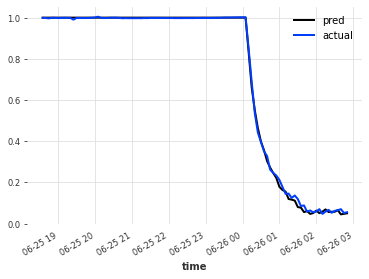

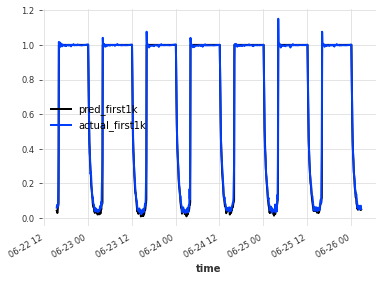

963 963


100%|██████████| 579/579 [00:04<00:00, 119.45it/s]


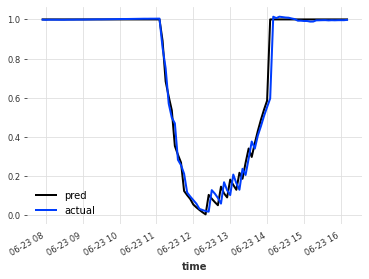

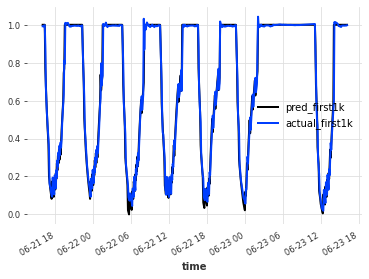

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 116.93it/s]


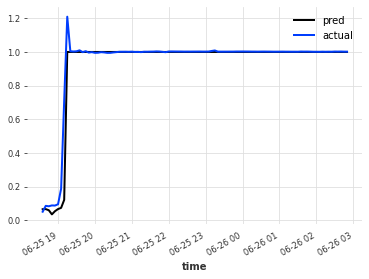

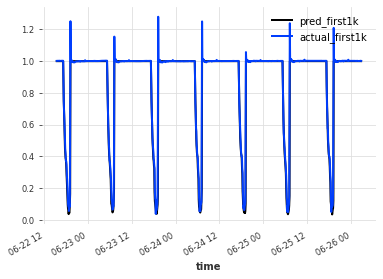

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 115.01it/s]


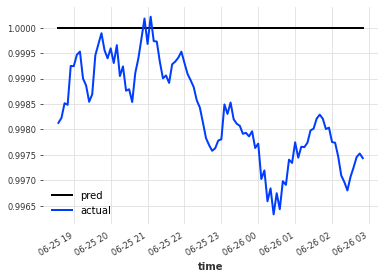

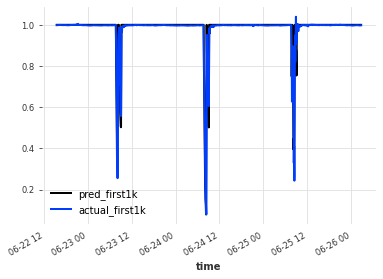

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 118.41it/s]


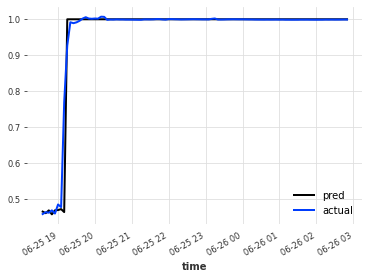

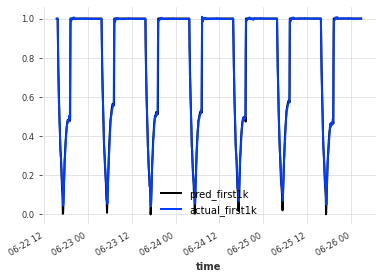

963 963


100%|██████████| 579/579 [00:04<00:00, 118.04it/s]


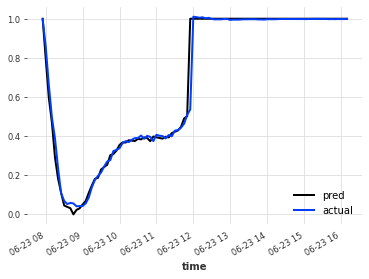

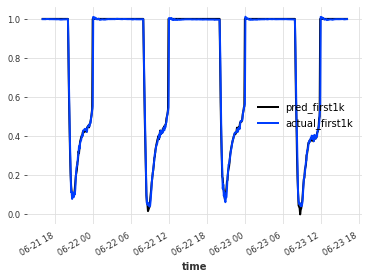

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 116.25it/s]


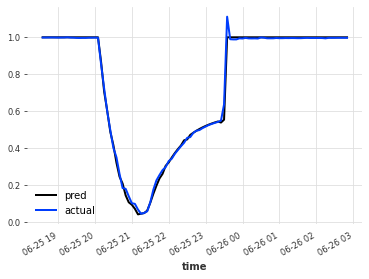

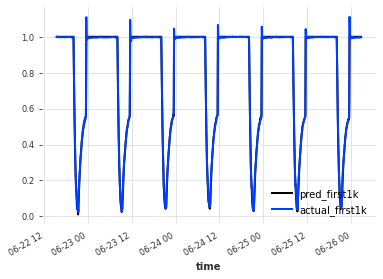

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 115.53it/s]


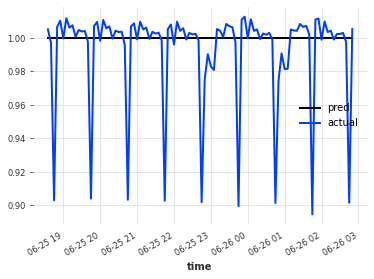

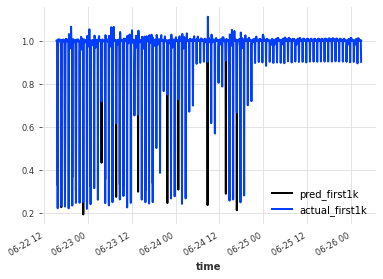

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 116.06it/s]


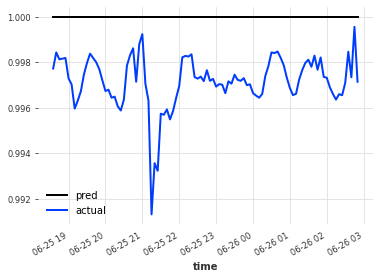

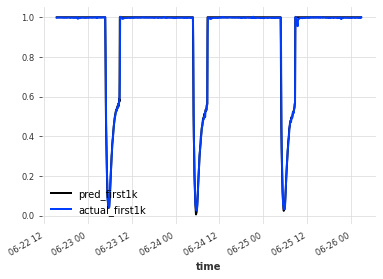

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 117.11it/s]


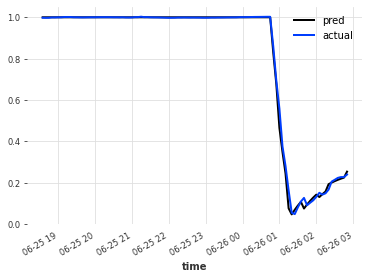

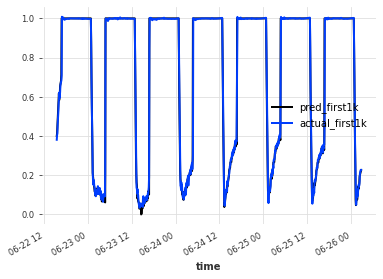

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 116.47it/s]


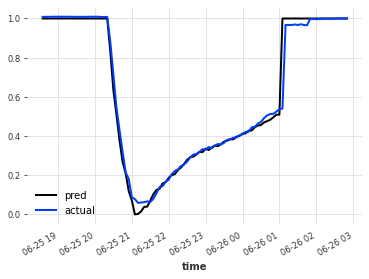

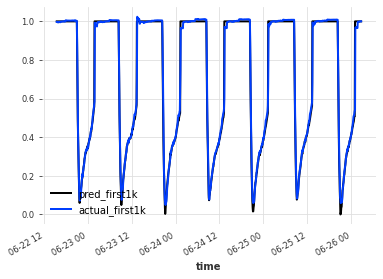

1263 1263


100%|██████████| 759/759 [00:06<00:00, 115.69it/s]


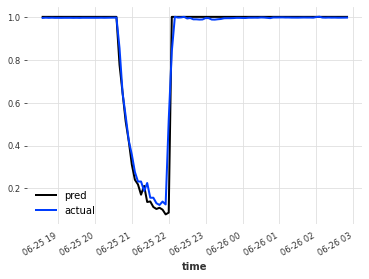

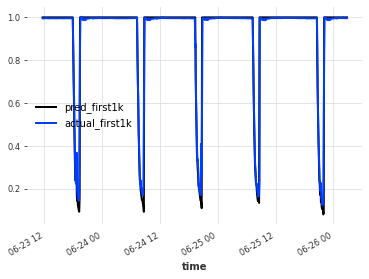

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 116.34it/s]


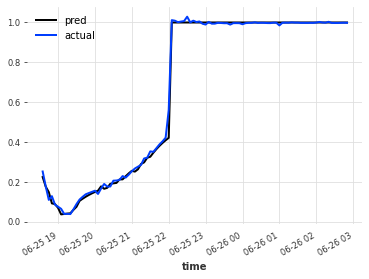

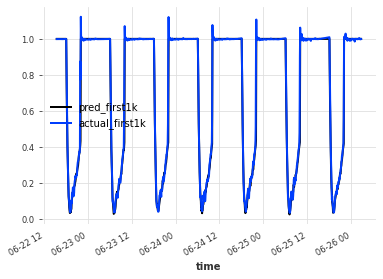

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 115.00it/s]


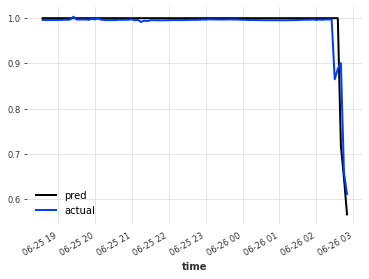

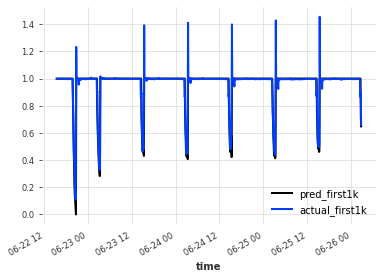

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 114.00it/s]


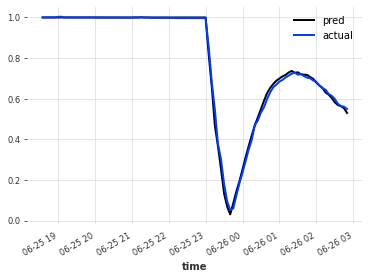

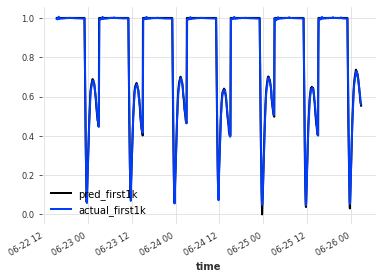

1667 1667


100%|██████████| 1001/1001 [00:08<00:00, 115.77it/s]


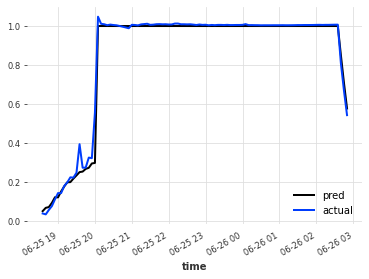

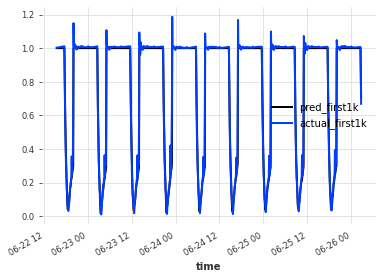

In [78]:
results_for_valid1, true_valid1, predict__valid1 = validate_model(model=model_all_pumps, 
                        validation_target=val_target1,
                        validation_cov=val_cov1, 
                        model_name = 'tcn1')

1334 1334


100%|██████████| 801/801 [00:06<00:00, 119.19it/s]


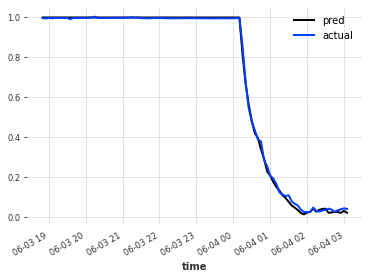

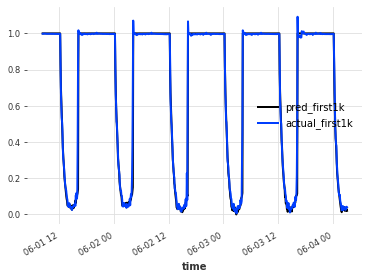

1334 1334


100%|██████████| 801/801 [00:06<00:00, 119.33it/s]


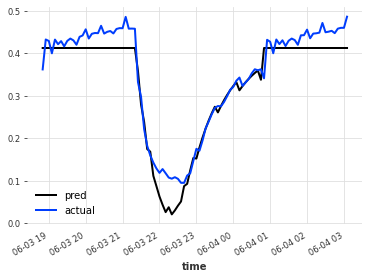

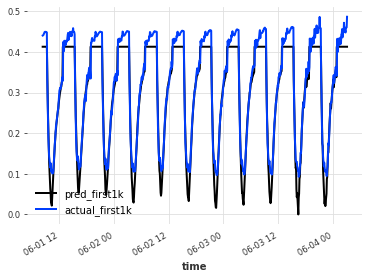

1334 1334


100%|██████████| 801/801 [00:06<00:00, 119.10it/s]


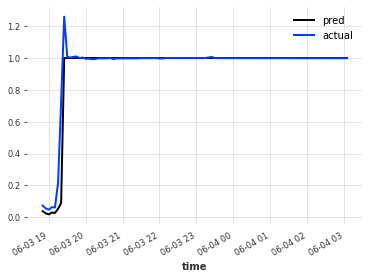

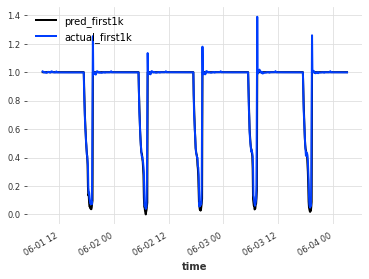

1334 1334


100%|██████████| 801/801 [00:06<00:00, 117.77it/s]


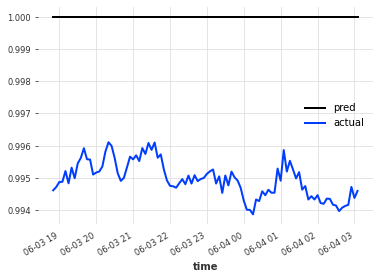

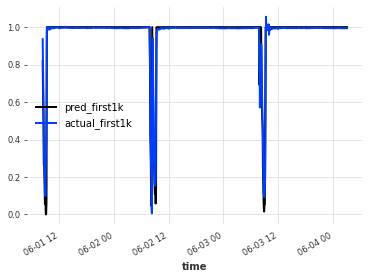

1334 1334


100%|██████████| 801/801 [00:06<00:00, 119.07it/s]


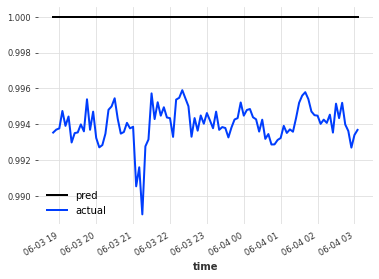

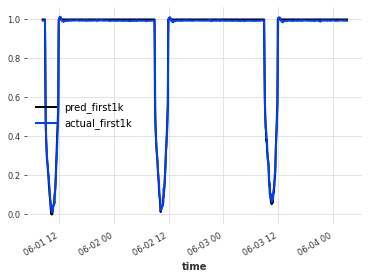

1334 1334


100%|██████████| 801/801 [00:06<00:00, 117.68it/s]


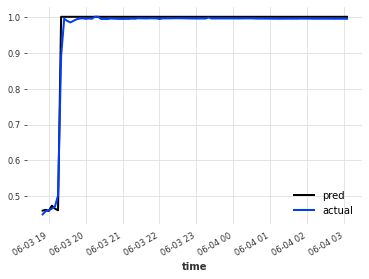

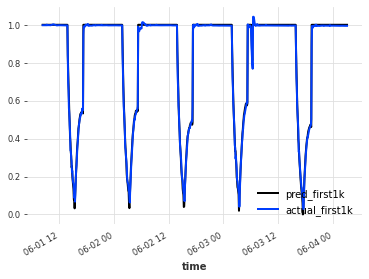

1334 1334


100%|██████████| 801/801 [00:06<00:00, 114.97it/s]


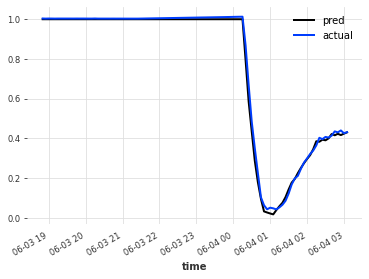

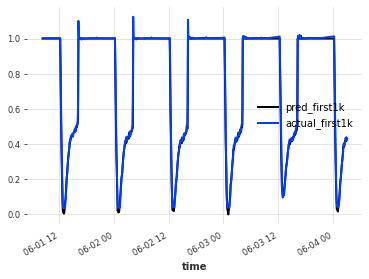

1334 1334


100%|██████████| 801/801 [00:06<00:00, 116.13it/s]


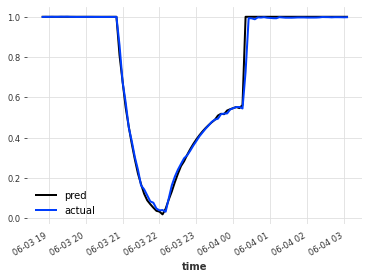

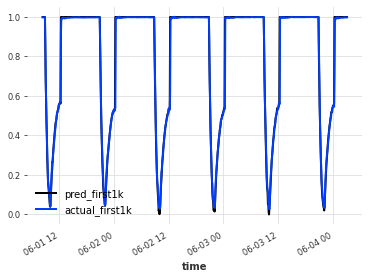

1334 1334


100%|██████████| 801/801 [00:06<00:00, 115.84it/s]


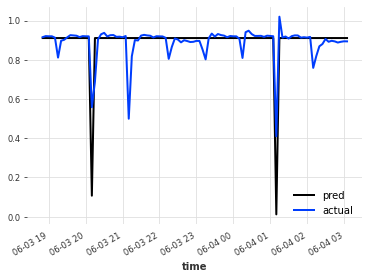

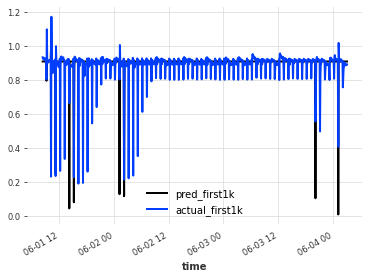

1334 1334


100%|██████████| 801/801 [00:06<00:00, 116.00it/s]


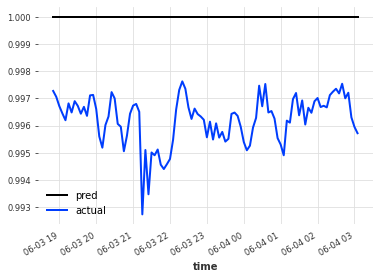

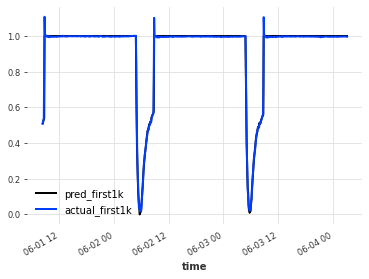

1334 1334


100%|██████████| 801/801 [00:06<00:00, 115.35it/s]


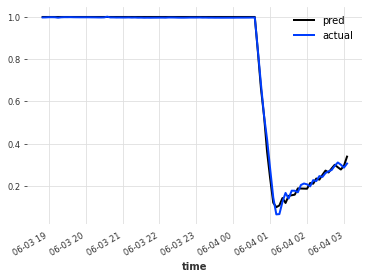

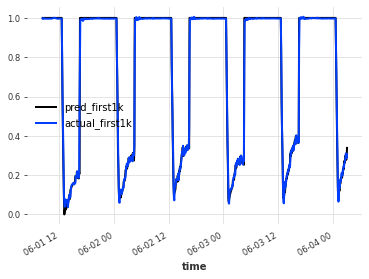

1334 1334


100%|██████████| 801/801 [00:06<00:00, 115.60it/s]


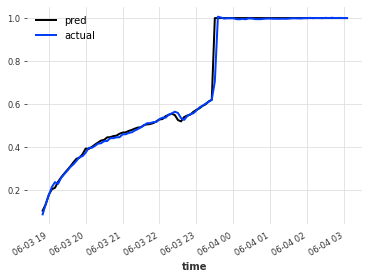

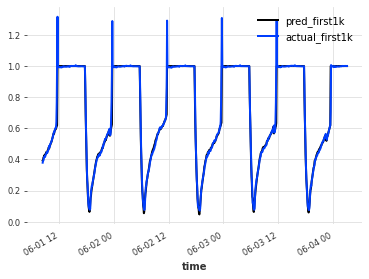

1334 1334


100%|██████████| 801/801 [00:07<00:00, 114.37it/s]


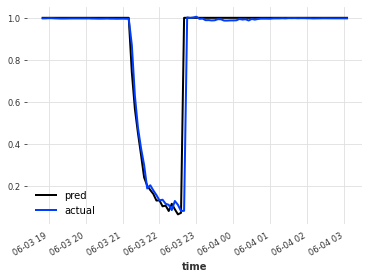

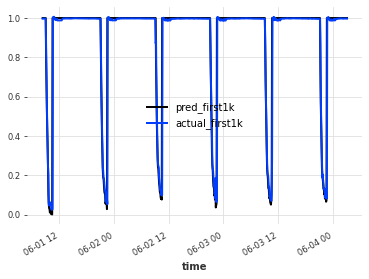

1334 1334


100%|██████████| 801/801 [00:06<00:00, 114.83it/s]


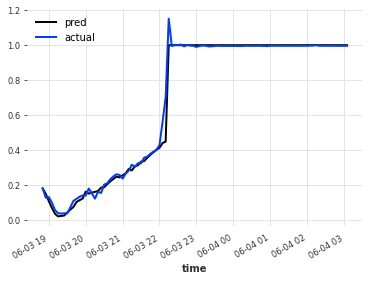

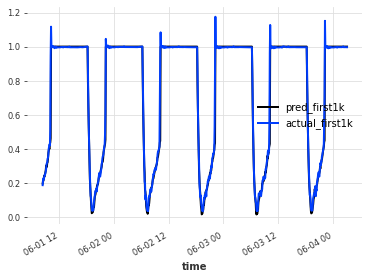

1334 1334


100%|██████████| 801/801 [00:07<00:00, 113.91it/s]


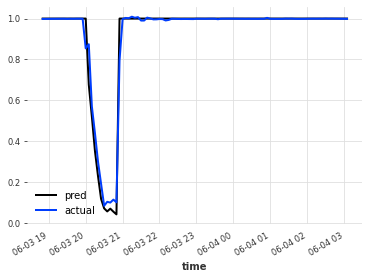

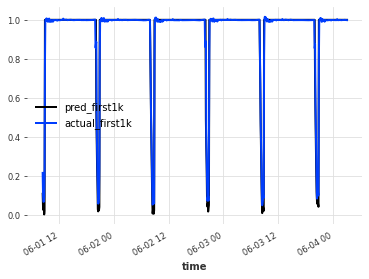

1334 1334


100%|██████████| 801/801 [00:06<00:00, 115.48it/s]


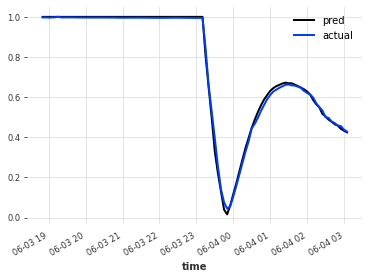

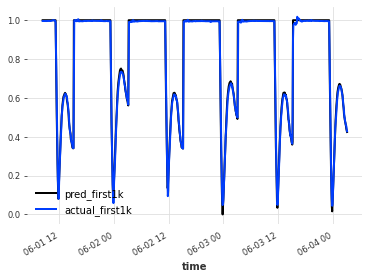

1334 1334


100%|██████████| 801/801 [00:07<00:00, 114.37it/s]


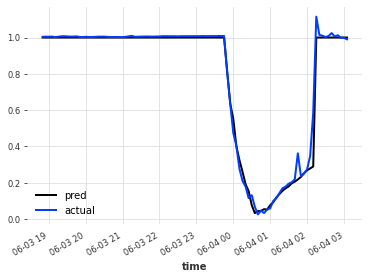

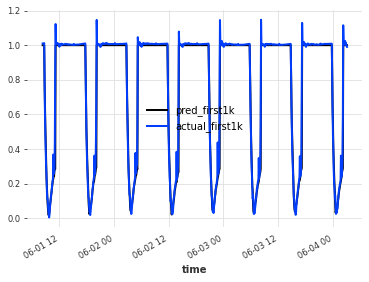

In [79]:
results_for_valid2, true_valid2, predict__valid2 = validate_model(model=model_all_pumps, 
                        validation_target=val_target2,
                        validation_cov=val_cov2, 
                        model_name = 'tcn2')

In [80]:
valid_tcn = {'Valid1':{'true':true_valid1, 
                      'prediction':predict__valid1}, 
             'Valid2':{'true':true_valid2, 
                      'prediction':predict__valid2}}

In [81]:
validtcn_results = score_model(valid_tcn)
validtcn_results.loc['mean_tcn_valid'] = validtcn_results.mean()

validtcn_results.to_csv('tcn_valid_results.csv') 
validtcn_results

mape     smape       mae  r2_value
Valid1          3.218127e+11  0.040177  0.011989  0.976914
Valid2          2.749614e+11  0.048697  0.012878  0.980359
mean_tcn_valid  2.983871e+11  0.044437  0.012434  0.978636

# transformers

In [82]:
from darts.models import TransformerModel


In [83]:
trans_model = TransformerModel(
    input_chunk_length = 144,
    output_chunk_length = 1,
    batch_size = 32,
    n_epochs = EPOCH,
    model_name = 'all_pumps_transformer',
    log_tensorboard=True,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    random_state=0
)

In [84]:
trans_model.fit(series=train_target_v3,
              past_covariates=train_cov_v3,
              val_series=val_target_v3,
              val_past_covariates=val_cov_v3,
              verbose=True)

  1%|          | 1/100 [02:56<4:50:58, 176.35s/it]

 11%|█         | 11/100 [29:43<4:04:22, 164.75s/it]

 21%|██        | 21/100 [56:25<3:34:41, 163.05s/it]

 31%|███       | 31/100 [1:23:03<3:07:38, 163.17s/it]

 41%|████      | 41/100 [1:49:56<2:44:13, 167.01s/it]

 51%|█████     | 51/100 [2:17:03<2:15:17, 165.66s/it]

 61%|██████    | 61/100 [2:44:20<1:48:33, 167.02s/it]

 71%|███████   | 71/100 [3:11:26<1:20:05, 165.70s/it]

 81%|████████  | 81/100 [3:38:11<51:59, 164.19s/it]

 91%|█████████ | 91/100 [4:05:03<24:44, 164.91s/it]

100%|██████████| 100/100 [4:28:55<00:00, 161.36s/it]


In [85]:
trans_model.save_model('allpumps_transformer.pth.tar')

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 90.96it/s]


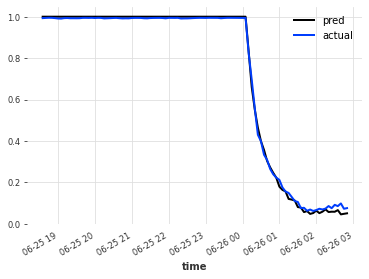

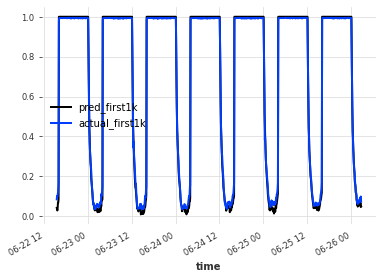

963 963


100%|██████████| 579/579 [00:06<00:00, 92.05it/s]


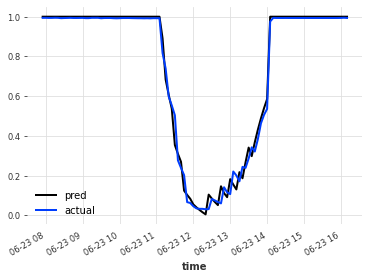

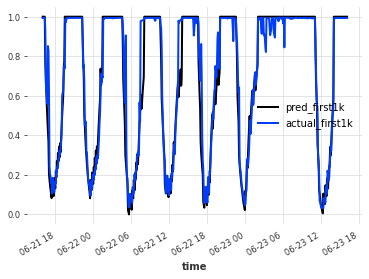

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 92.65it/s]


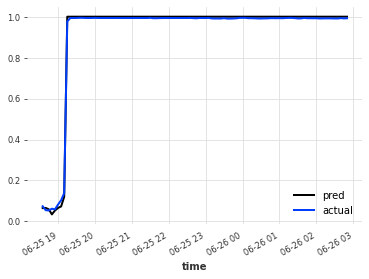

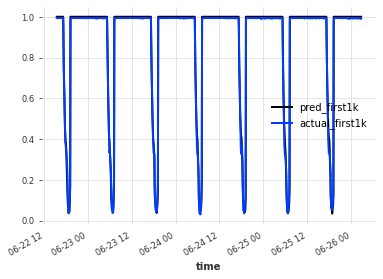

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 93.37it/s]


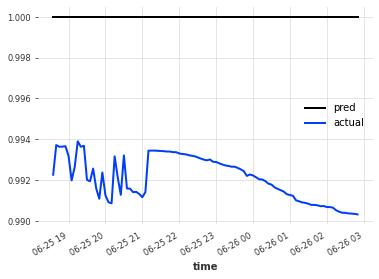

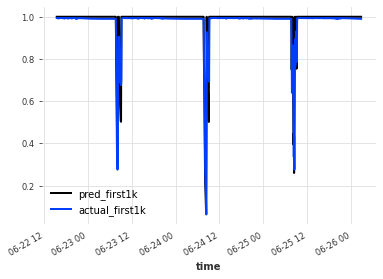

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 90.57it/s]


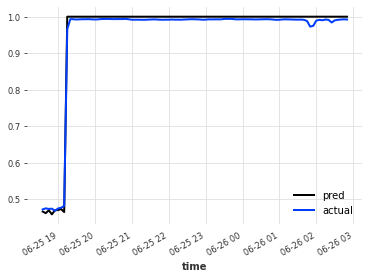

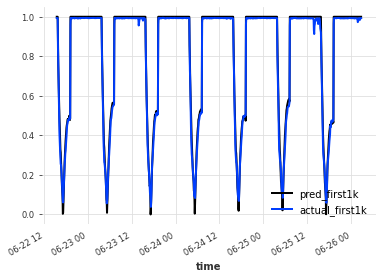

963 963


100%|██████████| 579/579 [00:06<00:00, 91.38it/s]


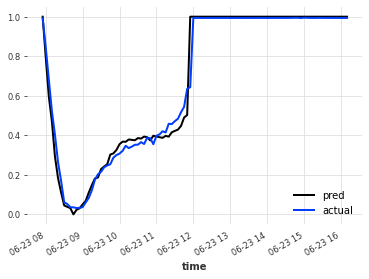

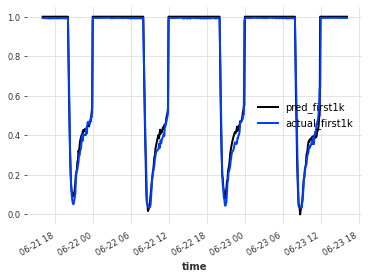

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 88.14it/s]


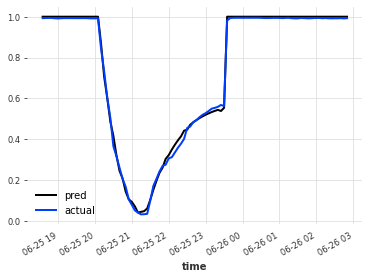

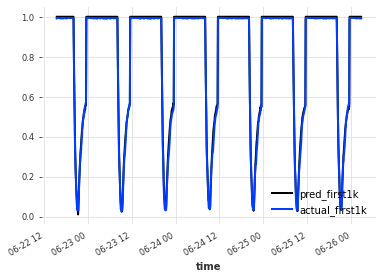

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 90.90it/s]


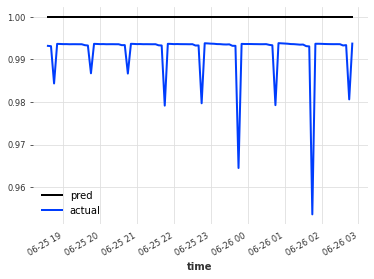

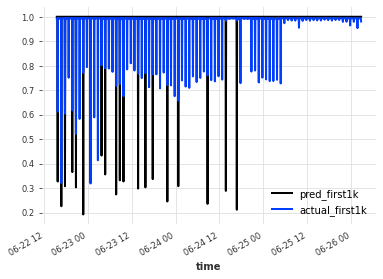

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 91.64it/s]


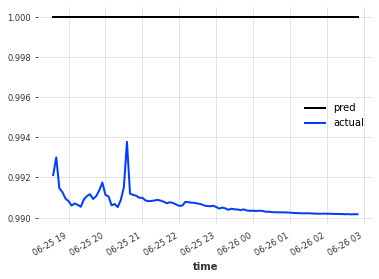

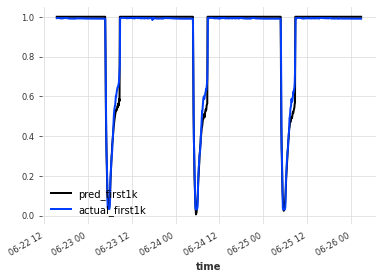

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 91.87it/s]


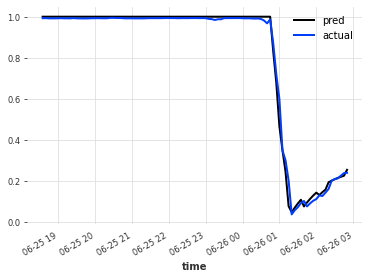

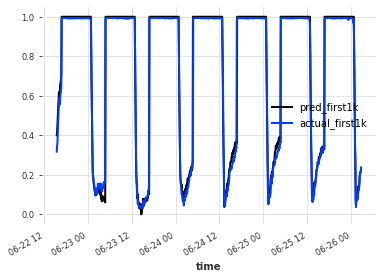

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 90.63it/s]


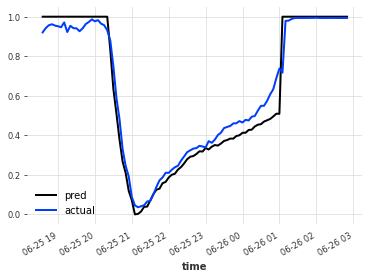

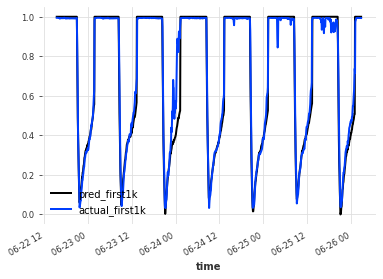

1263 1263


100%|██████████| 759/759 [00:08<00:00, 90.40it/s]


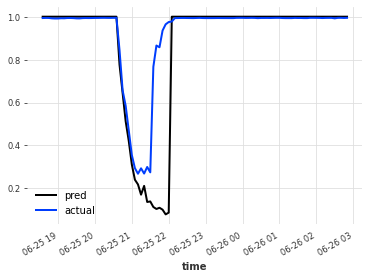

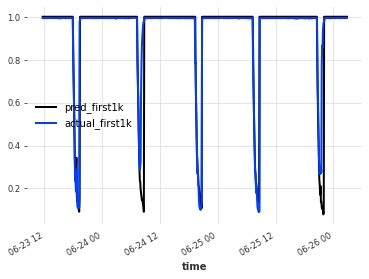

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 91.41it/s]


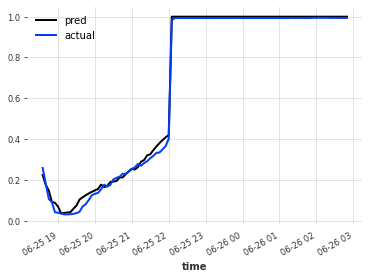

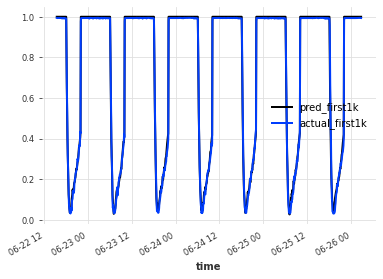

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 89.30it/s]


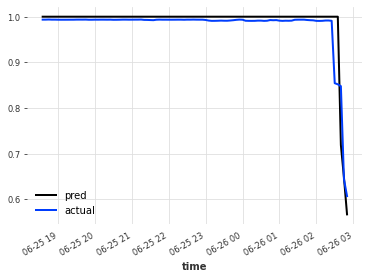

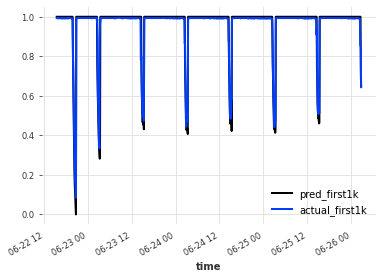

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 91.69it/s]


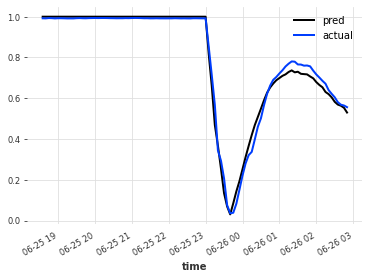

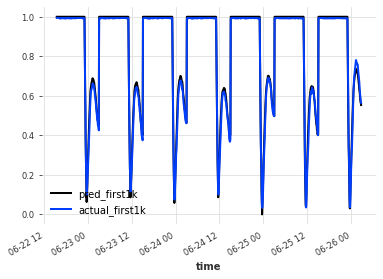

1667 1667


100%|██████████| 1001/1001 [00:11<00:00, 90.65it/s]


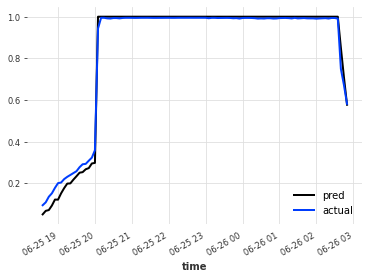

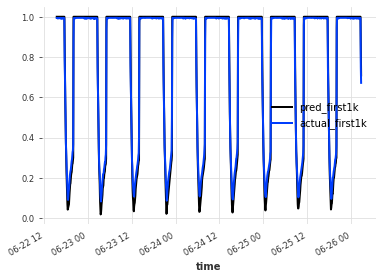

In [86]:
results_for_valid1trans, true_valid1trans, predict__valid1trans = validate_model(model=trans_model, 
                        validation_target=val_target1,
                        validation_cov=val_cov1, 
                        model_name = 'trans1')

1334 1334


100%|██████████| 801/801 [00:08<00:00, 92.82it/s]


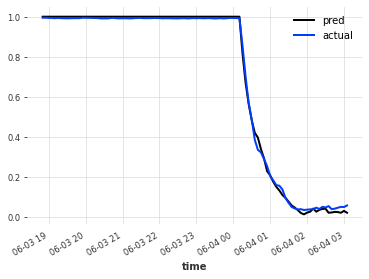

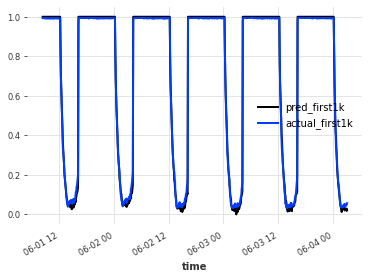

1334 1334


100%|██████████| 801/801 [00:08<00:00, 94.22it/s]


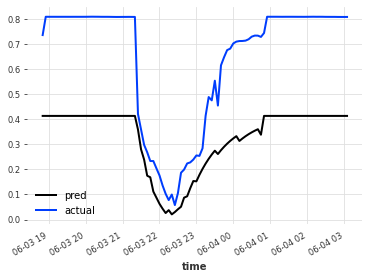

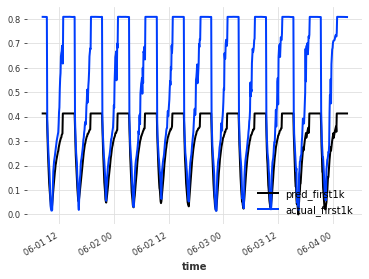

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.44it/s]


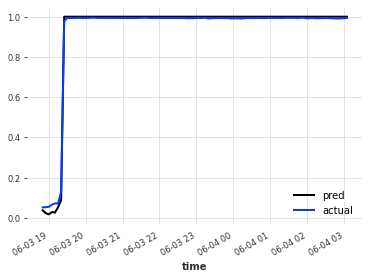

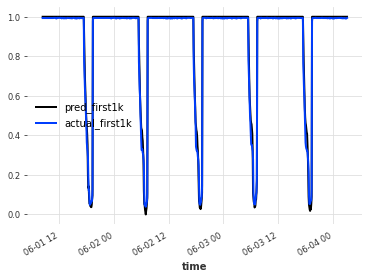

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.15it/s]


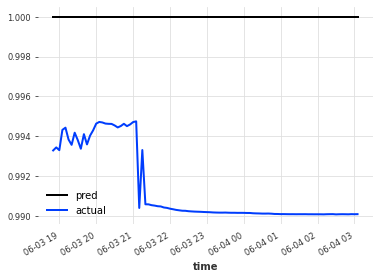

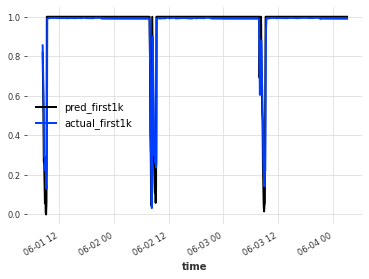

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.24it/s]


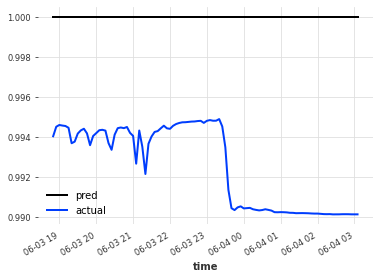

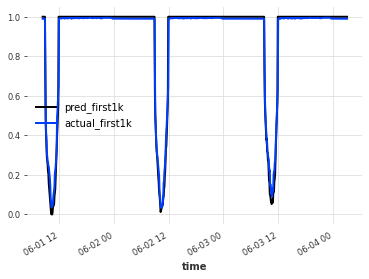

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.10it/s]


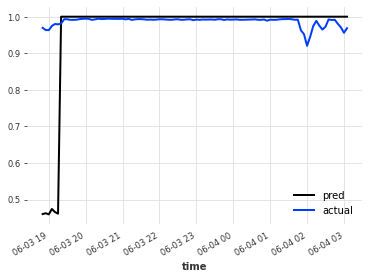

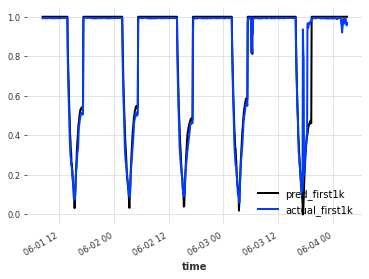

1334 1334


100%|██████████| 801/801 [00:08<00:00, 90.54it/s]


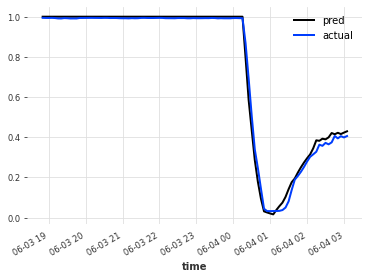

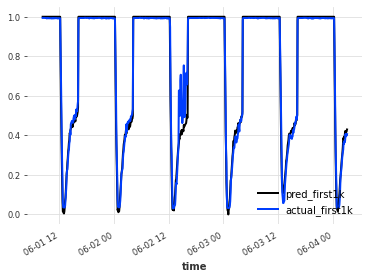

1334 1334


100%|██████████| 801/801 [00:08<00:00, 92.32it/s]


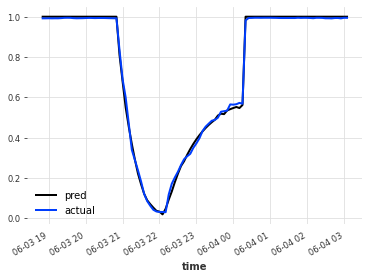

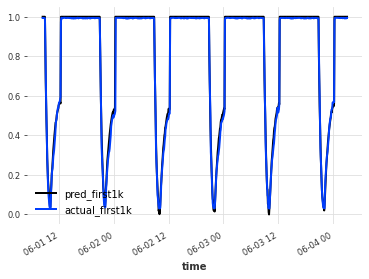

1334 1334


100%|██████████| 801/801 [00:08<00:00, 92.64it/s]


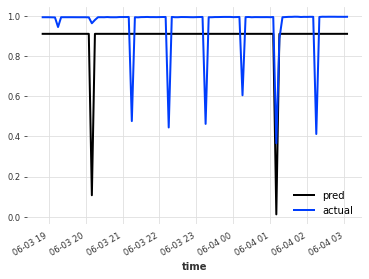

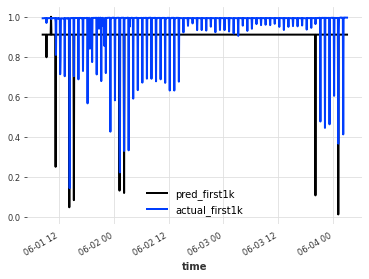

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.20it/s]


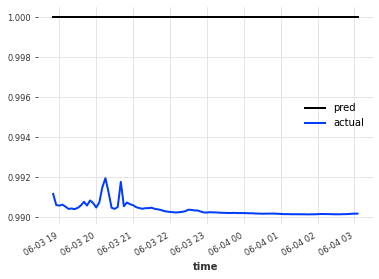

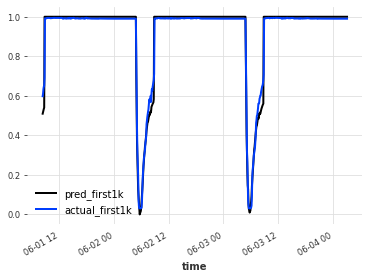

1334 1334


100%|██████████| 801/801 [00:08<00:00, 92.70it/s]


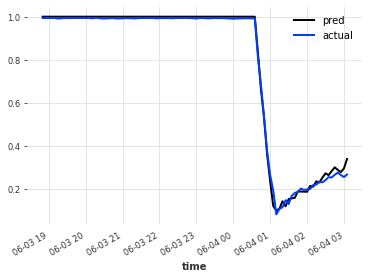

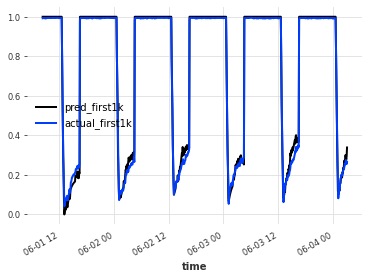

1334 1334


100%|██████████| 801/801 [00:08<00:00, 89.36it/s]


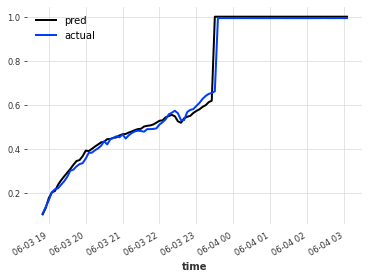

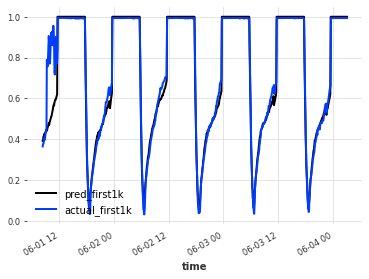

1334 1334


100%|██████████| 801/801 [00:08<00:00, 91.03it/s]


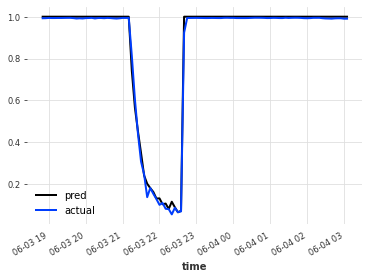

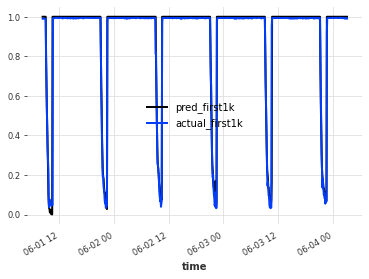

1334 1334


100%|██████████| 801/801 [00:08<00:00, 91.65it/s]


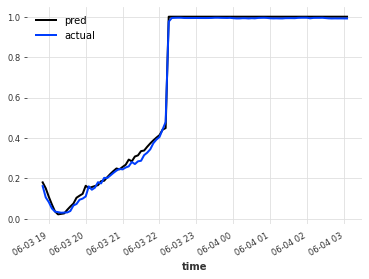

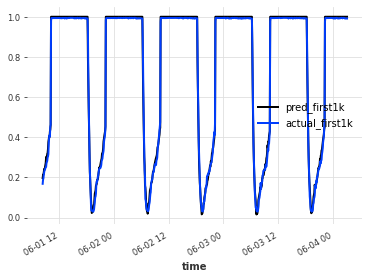

1334 1334


100%|██████████| 801/801 [00:08<00:00, 90.54it/s]


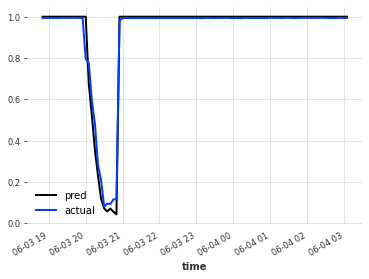

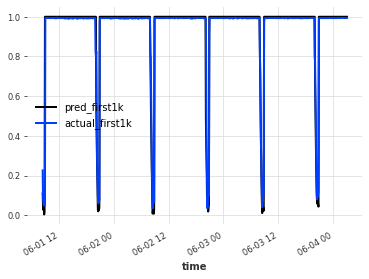

1334 1334


100%|██████████| 801/801 [00:08<00:00, 91.88it/s]


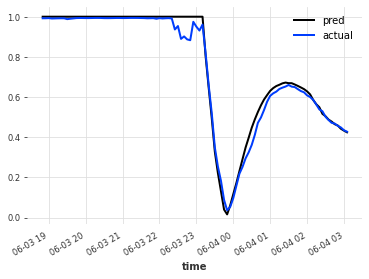

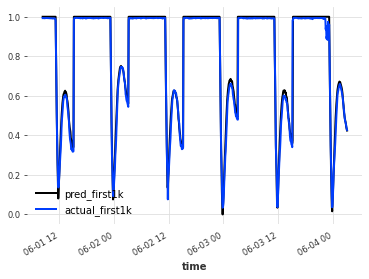

1334 1334


100%|██████████| 801/801 [00:08<00:00, 90.99it/s]


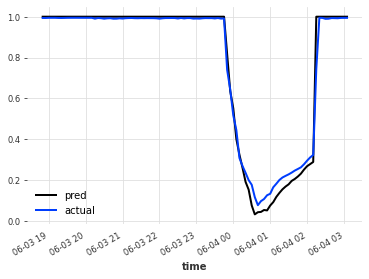

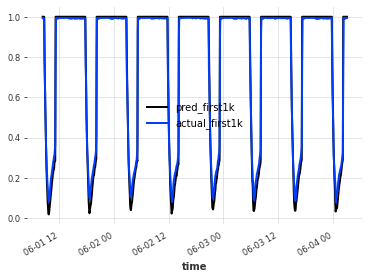

In [87]:
results_for_valid2trans, true_valid2trans, predict__valid2trans = validate_model(model=trans_model, 
                        validation_target=val_target2,
                        validation_cov=val_cov2, 
                        model_name = 'trans2')

In [88]:
valid_trans = {'Valid1':{'true':true_valid1trans, 
                      'prediction':predict__valid1trans}, 
             'Valid2':{'true':true_valid2trans, 
                      'prediction':predict__valid2trans}}

In [89]:
validtrans_results = score_model(valid_trans)
validtrans_results.loc['mean_transformers_valid'] = validtrans_results.mean()

validtrans_results.to_csv('transformers_valid_results.csv') 
validtrans_results

mape     smape       mae  r2_value
Valid1                   1.037243e+11  0.052420  0.017278  0.974909
Valid2                   4.646948e+11  0.087622  0.033893  0.929604
mean_transformers_valid  2.842096e+11  0.070021  0.025585  0.952257

# nbeats

In [90]:
from darts.models import NBEATSModel


In [91]:
model_nbeats = NBEATSModel(
    input_chunk_length=144,
    output_chunk_length=1,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name='nbeats_allpumps'
)

In [92]:
model_nbeats.fit(series=train_target_v3,
              past_covariates=train_cov_v3,
              val_series=val_target_v3,
              val_past_covariates=val_cov_v3,
              verbose=True)

  1%|          | 1/100 [01:16<2:05:33, 76.09s/it]

  2%|▏         | 2/100 [02:31<2:03:53, 75.85s/it]

  3%|▎         | 3/100 [03:47<2:02:52, 76.01s/it]

  4%|▍         | 4/100 [05:04<2:01:56, 76.22s/it]

  5%|▌         | 5/100 [06:21<2:00:55, 76.38s/it]

  6%|▌         | 6/100 [07:37<1:59:29, 76.28s/it]

  7%|▋         | 7/100 [08:53<1:57:58, 76.11s/it]

  8%|▊         | 8/100 [10:08<1:56:31, 76.00s/it]

  9%|▉         | 9/100 [11:24<1:55:21, 76.06s/it]

 10%|█         | 10/100 [12:40<1:53:57, 75.97s/it]

 11%|█         | 11/100 [13:55<1:52:21, 75.75s/it]

 12%|█▏        | 12/100 [15:11<1:51:11, 75.81s/it]

 13%|█▎        | 13/100 [16:28<1:50:11, 76.00s/it]

 14%|█▍        | 14/100 [17:44<1:49:00, 76.05s/it]

 15%|█▌        | 15/100 [19:00<1:47:51, 76.14s/it]

 16%|█▌        | 16/100 [20:17<1:46:37, 76.16s/it]

 17%|█▋        | 17/100 [21:33<1:45:30, 76.27s/it]

 18%|█▊        | 18/100 [22:49<1:44:11, 76.23s/it]

 19%|█▉        | 19/100 [24:05<1:42:52, 76.20s/it]

 20%|██        | 20/100 [25:22<1:41:35, 76.20s/it]

 21%|██        | 21/100 [26:38<1:40:29, 76.33s/it]

 22%|██▏       | 22/100 [27:55<1:39:14, 76.33s/it]

 23%|██▎       | 23/100 [29:11<1:37:53, 76.28s/it]

 24%|██▍       | 24/100 [30:27<1:36:28, 76.17s/it]

 25%|██▌       | 25/100 [31:42<1:34:57, 75.97s/it]

 26%|██▌       | 26/100 [32:57<1:33:18, 75.66s/it]

 27%|██▋       | 27/100 [34:12<1:31:44, 75.41s/it]

 28%|██▊       | 28/100 [35:27<1:30:16, 75.23s/it]

 29%|██▉       | 29/100 [36:42<1:29:01, 75.23s/it]

 30%|███       | 30/100 [37:57<1:27:46, 75.23s/it]

 31%|███       | 31/100 [39:13<1:26:35, 75.30s/it]

 32%|███▏      | 32/100 [40:28<1:25:17, 75.25s/it]

 33%|███▎      | 33/100 [41:43<1:24:01, 75.24s/it]

 34%|███▍      | 34/100 [42:58<1:22:47, 75.26s/it]

 35%|███▌      | 35/100 [44:14<1:21:39, 75.38s/it]

 36%|███▌      | 36/100 [45:29<1:20:19, 75.30s/it]

 37%|███▋      | 37/100 [46:44<1:18:55, 75.16s/it]

 38%|███▊      | 38/100 [47:58<1:17:29, 74.99s/it]

 39%|███▉      | 39/100 [49:13<1:16:14, 74.99s/it]

 40%|████      | 40/100 [50:28<1:14:51, 74.85s/it]

 41%|████      | 41/100 [51:43<1:13:33, 74.81s/it]

 42%|████▏     | 42/100 [52:57<1:12:14, 74.73s/it]

 43%|████▎     | 43/100 [54:12<1:10:54, 74.64s/it]

 44%|████▍     | 44/100 [55:26<1:09:39, 74.63s/it]

 45%|████▌     | 45/100 [56:41<1:08:26, 74.66s/it]

 46%|████▌     | 46/100 [57:55<1:07:07, 74.59s/it]

 47%|████▋     | 47/100 [59:10<1:05:49, 74.51s/it]

 48%|████▊     | 48/100 [1:00:24<1:04:30, 74.43s/it]

 49%|████▉     | 49/100 [1:01:39<1:03:16, 74.45s/it]

 50%|█████     | 50/100 [1:02:53<1:02:04, 74.49s/it]

 51%|█████     | 51/100 [1:04:07<1:00:47, 74.44s/it]

 52%|█████▏    | 52/100 [1:05:22<59:32, 74.43s/it]  

 53%|█████▎    | 53/100 [1:06:36<58:15, 74.36s/it]

 54%|█████▍    | 54/100 [1:07:50<56:57, 74.29s/it]

 55%|█████▌    | 55/100 [1:09:05<55:44, 74.33s/it]

 56%|█████▌    | 56/100 [1:10:19<54:35, 74.43s/it]

 57%|█████▋    | 57/100 [1:11:34<53:19, 74.41s/it]

 58%|█████▊    | 58/100 [1:12:48<52:00, 74.30s/it]

 59%|█████▉    | 59/100 [1:14:02<50:46, 74.31s/it]

 60%|██████    | 60/100 [1:15:16<49:33, 74.34s/it]

 61%|██████    | 61/100 [1:16:31<48:21, 74.39s/it]

 62%|██████▏   | 62/100 [1:17:45<47:03, 74.31s/it]

 63%|██████▎   | 63/100 [1:18:59<45:49, 74.31s/it]

 64%|██████▍   | 64/100 [1:20:14<44:35, 74.32s/it]

 65%|██████▌   | 65/100 [1:21:28<43:19, 74.27s/it]

 66%|██████▌   | 66/100 [1:22:42<42:05, 74.27s/it]

 67%|██████▋   | 67/100 [1:23:56<40:51, 74.29s/it]

 68%|██████▊   | 68/100 [1:25:11<39:36, 74.27s/it]

 69%|██████▉   | 69/100 [1:26:25<38:22, 74.28s/it]

 70%|███████   | 70/100 [1:27:39<37:05, 74.18s/it]

 71%|███████   | 71/100 [1:28:53<35:49, 74.13s/it]

 72%|███████▏  | 72/100 [1:30:07<34:33, 74.05s/it]

 73%|███████▎  | 73/100 [1:31:21<33:19, 74.05s/it]

 74%|███████▍  | 74/100 [1:32:35<32:04, 74.02s/it]

 75%|███████▌  | 75/100 [1:33:49<30:51, 74.05s/it]

 76%|███████▌  | 76/100 [1:35:03<29:38, 74.10s/it]

 77%|███████▋  | 77/100 [1:36:17<28:25, 74.14s/it]

 78%|███████▊  | 78/100 [1:37:31<27:10, 74.10s/it]

 79%|███████▉  | 79/100 [1:38:46<25:57, 74.16s/it]

 80%|████████  | 80/100 [1:40:00<24:44, 74.21s/it]

 81%|████████  | 81/100 [1:41:14<23:30, 74.23s/it]

 82%|████████▏ | 82/100 [1:42:28<22:14, 74.12s/it]

 83%|████████▎ | 83/100 [1:43:42<20:59, 74.11s/it]

 84%|████████▍ | 84/100 [1:44:56<19:46, 74.14s/it]

 85%|████████▌ | 85/100 [1:46:11<18:32, 74.14s/it]

 86%|████████▌ | 86/100 [1:47:24<17:16, 74.04s/it]

 87%|████████▋ | 87/100 [1:48:39<16:03, 74.09s/it]

 88%|████████▊ | 88/100 [1:49:53<14:49, 74.15s/it]

 89%|████████▉ | 89/100 [1:51:07<13:35, 74.10s/it]

 90%|█████████ | 90/100 [1:52:21<12:20, 74.04s/it]

 91%|█████████ | 91/100 [1:53:35<11:05, 73.98s/it]

 92%|█████████▏| 92/100 [1:54:49<09:52, 74.00s/it]

 93%|█████████▎| 93/100 [1:56:03<08:38, 74.07s/it]

 94%|█████████▍| 94/100 [1:57:17<07:24, 74.02s/it]

 95%|█████████▌| 95/100 [1:58:31<06:10, 74.05s/it]

 96%|█████████▌| 96/100 [1:59:45<04:56, 74.03s/it]

 97%|█████████▋| 97/100 [2:00:59<03:41, 73.96s/it]

 98%|█████████▊| 98/100 [2:02:12<02:27, 73.92s/it]

 99%|█████████▉| 99/100 [2:03:26<01:13, 73.92s/it]

100%|██████████| 100/100 [2:04:41<00:00, 74.81s/it]

In [93]:
model_nbeats.save_model('allpumps_nbeats.pth.tar')

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 97.90it/s]


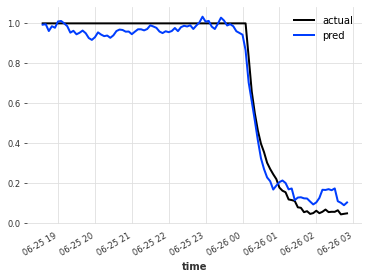

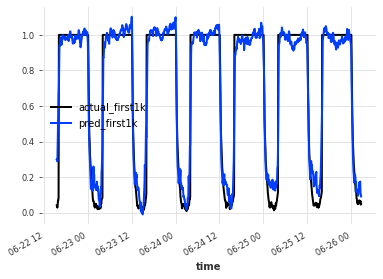

963 963


100%|██████████| 579/579 [00:05<00:00, 97.43it/s]


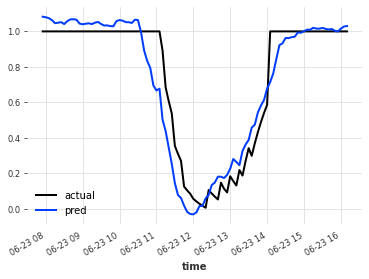

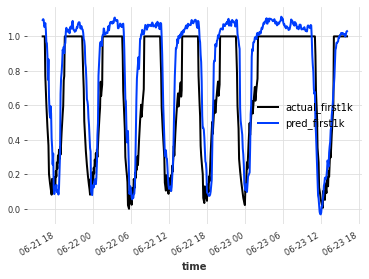

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 96.07it/s]


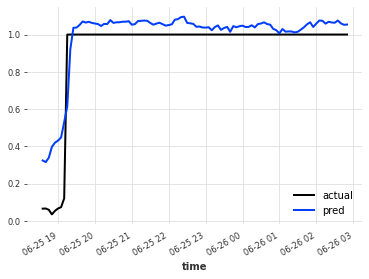

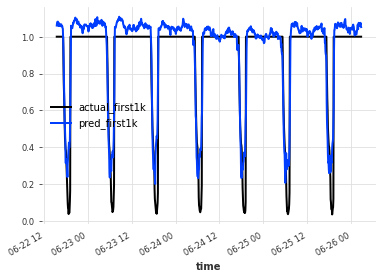

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 96.36it/s]


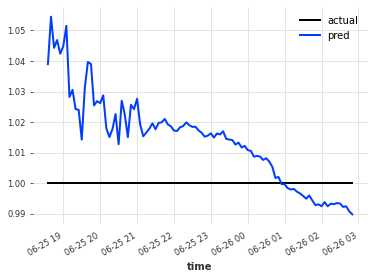

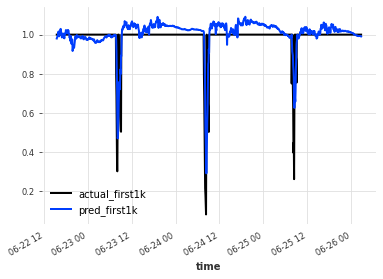

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 92.95it/s]


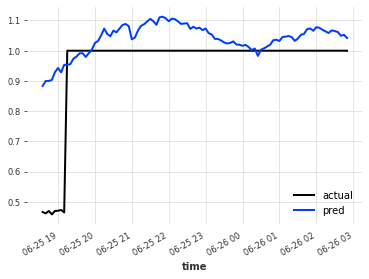

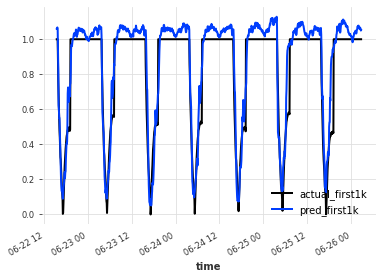

963 963


100%|██████████| 579/579 [00:06<00:00, 95.24it/s]


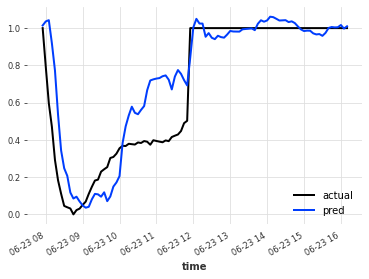

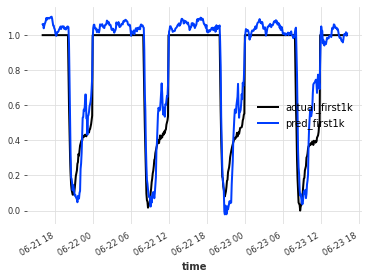

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 94.90it/s]


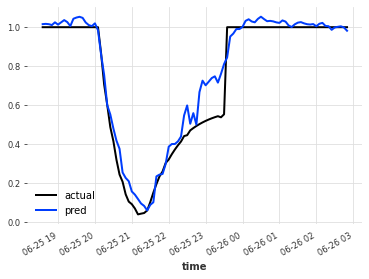

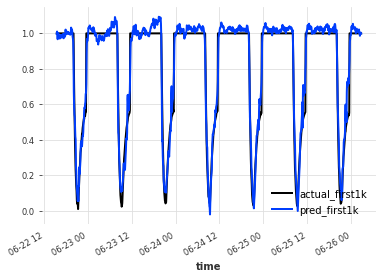

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 95.08it/s]


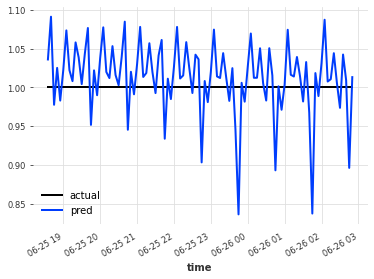

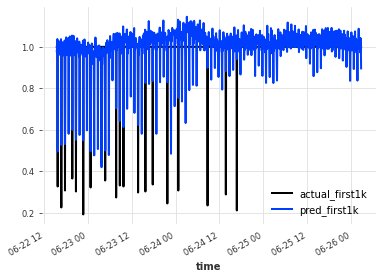

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 93.91it/s]


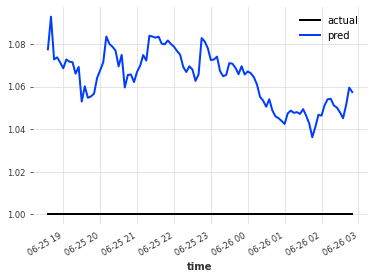

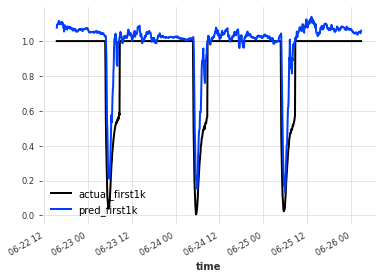

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 92.52it/s]


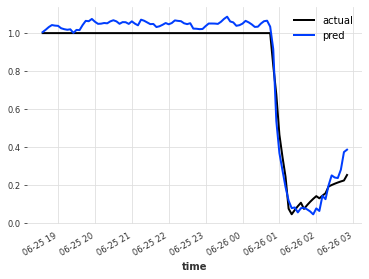

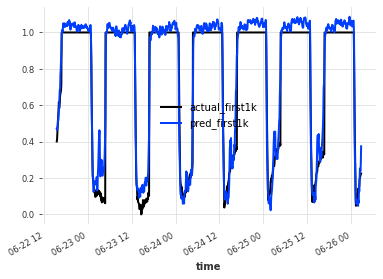

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 91.42it/s]


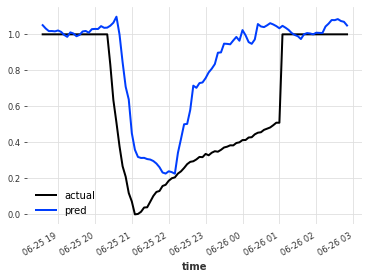

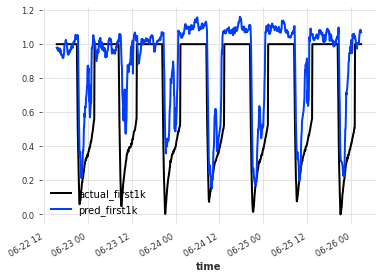

1263 1263


100%|██████████| 759/759 [00:08<00:00, 91.36it/s]


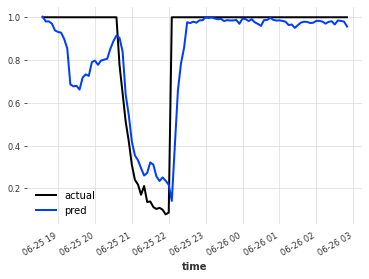

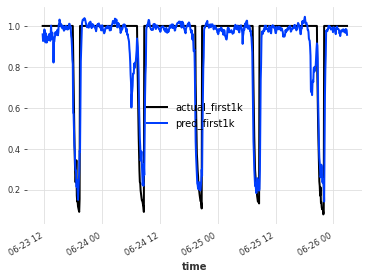

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 91.24it/s]


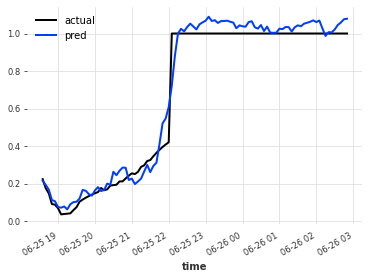

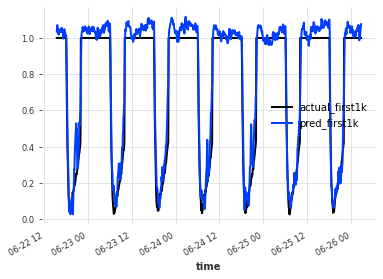

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 93.55it/s]


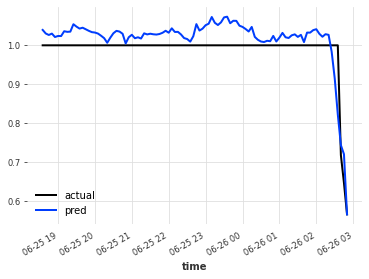

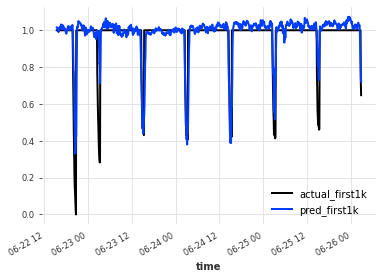

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 92.65it/s]


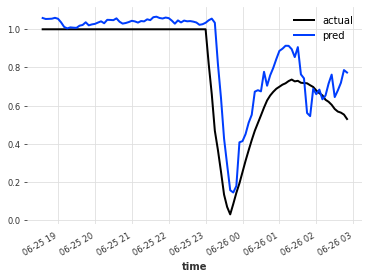

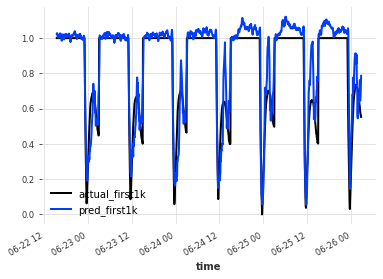

1667 1667


100%|██████████| 1001/1001 [00:10<00:00, 92.99it/s]


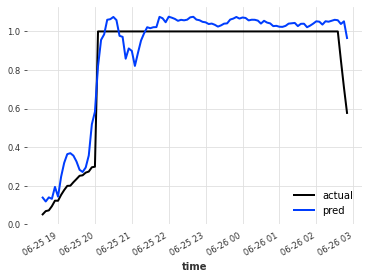

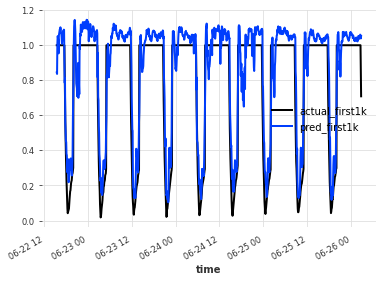

In [124]:
results_for_valid1nbeats, true_valid1nbeats, predict_valid1nbeats = validate_model(model=model_nbeats, 
                        validation_target=val_target1,
                        validation_cov=val_cov1, 
                        model_name = 'nbeats1')

1334 1334


100%|██████████| 801/801 [00:08<00:00, 98.49it/s] 


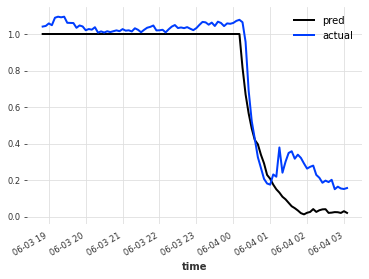

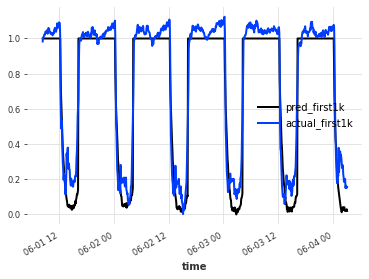

1334 1334


100%|██████████| 801/801 [00:08<00:00, 98.40it/s]


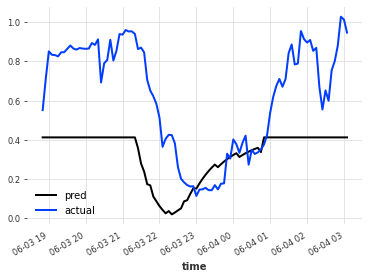

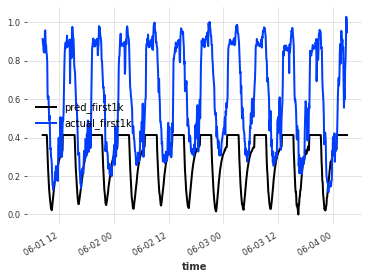

1334 1334


100%|██████████| 801/801 [00:08<00:00, 97.12it/s]


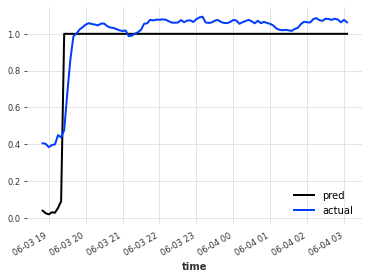

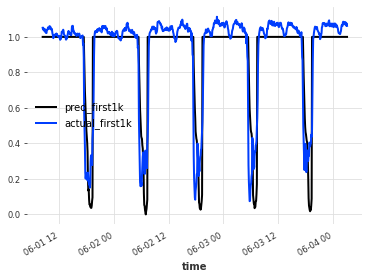

1334 1334


100%|██████████| 801/801 [00:08<00:00, 97.20it/s]


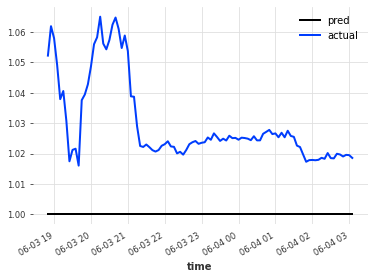

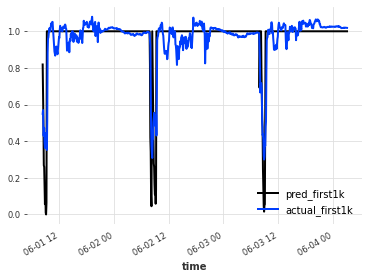

1334 1334


100%|██████████| 801/801 [00:08<00:00, 96.60it/s]


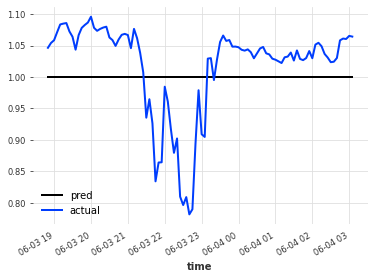

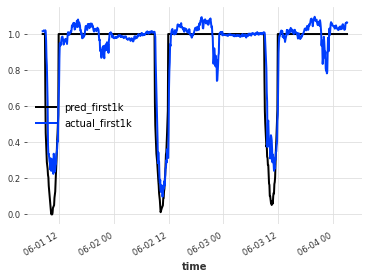

1334 1334


100%|██████████| 801/801 [00:08<00:00, 95.42it/s]


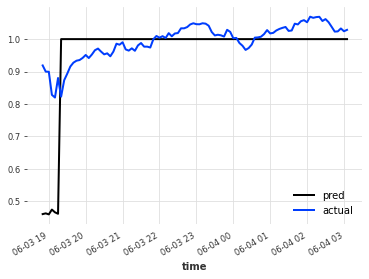

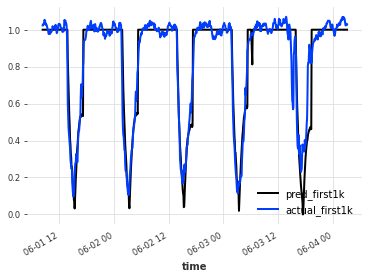

1334 1334


100%|██████████| 801/801 [00:08<00:00, 96.62it/s]


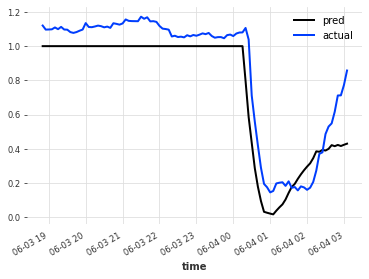

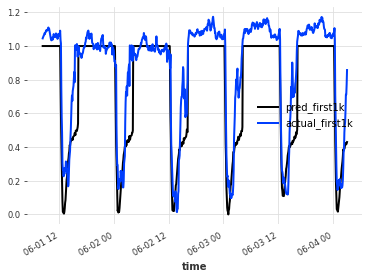

1334 1334


100%|██████████| 801/801 [00:08<00:00, 95.55it/s]


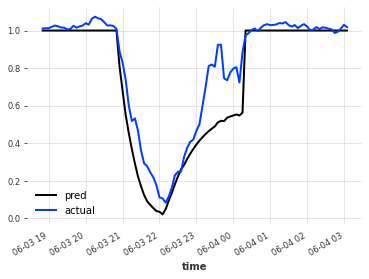

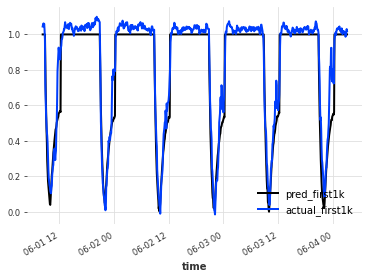

1334 1334


100%|██████████| 801/801 [00:08<00:00, 96.37it/s]


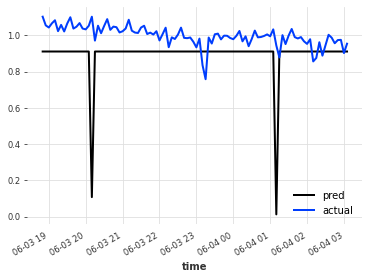

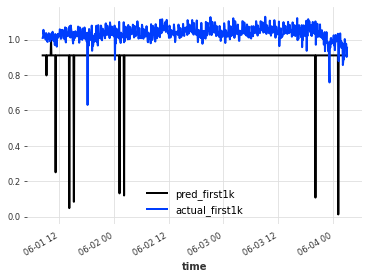

1334 1334


100%|██████████| 801/801 [00:08<00:00, 95.00it/s]


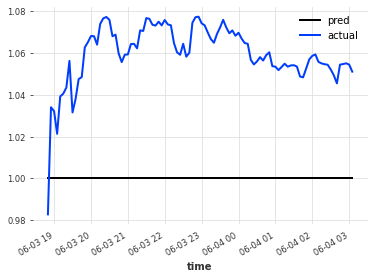

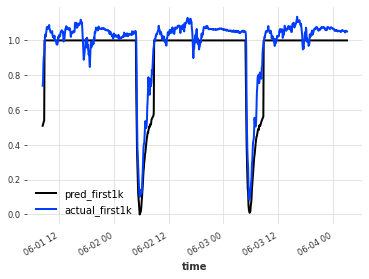

1334 1334


100%|██████████| 801/801 [00:08<00:00, 94.59it/s]


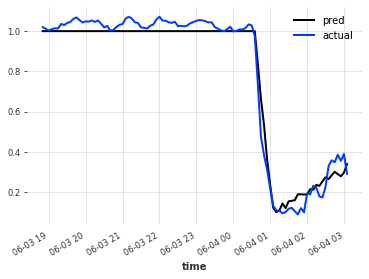

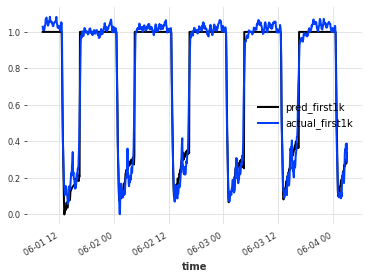

1334 1334


100%|██████████| 801/801 [00:08<00:00, 95.00it/s]


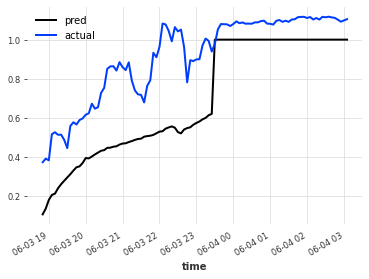

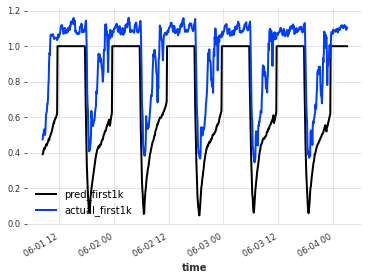

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.74it/s]


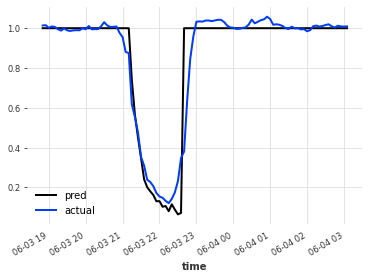

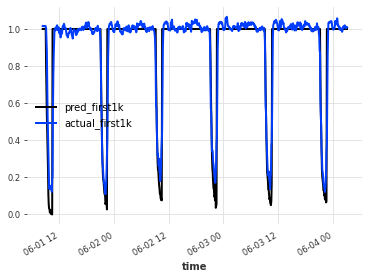

1334 1334


100%|██████████| 801/801 [00:08<00:00, 92.25it/s]


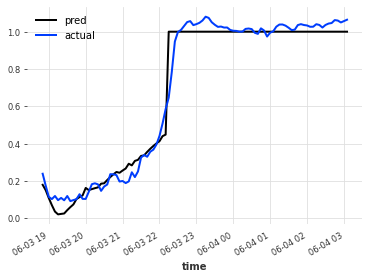

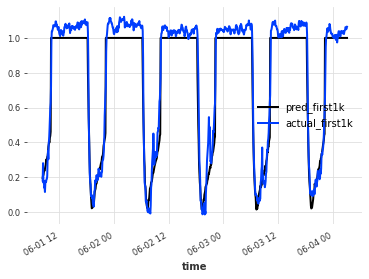

1334 1334


100%|██████████| 801/801 [00:08<00:00, 94.51it/s]


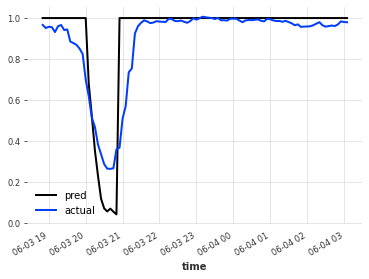

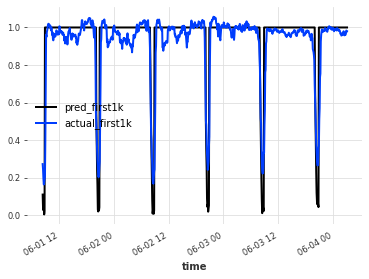

1334 1334


100%|██████████| 801/801 [00:08<00:00, 93.14it/s]


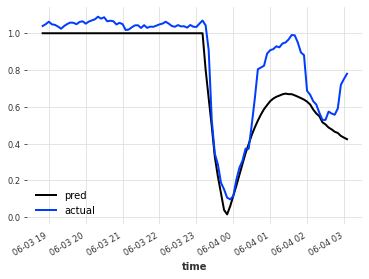

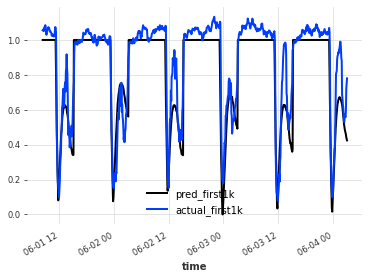

1334 1334


100%|██████████| 801/801 [00:08<00:00, 91.87it/s]


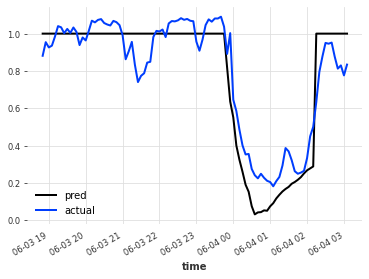

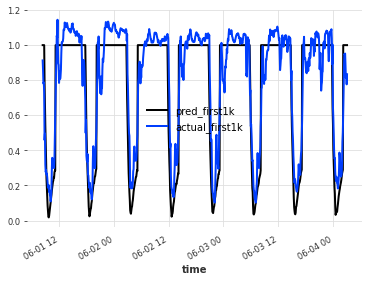

In [95]:
results_for_valid2nbeats, true_valid2nbeats, predict_valid2nbeats  = validate_model(model=model_nbeats, 
                        validation_target=val_target2,
                        validation_cov=val_cov2, 
                        model_name = 'nbeats2')

In [96]:
valid_nbeats = {'Valid1':{'true':true_valid1nbeats, 
                      'prediction':predict_valid1nbeats}, 
             'Valid2':{'true':true_valid2nbeats, 
                      'prediction':predict_valid2nbeats}}

In [97]:
valid_nbeats_results = score_model(valid_nbeats)
valid_nbeats_results.loc['mean_nbeats_valid'] = valid_nbeats_results.mean()

valid_nbeats_results.to_csv('nbeats_valid_results.csv') 
valid_nbeats_results

mape     smape       mae  r2_value
Valid1             4.016941e+11  0.153094  0.071963  0.845172
Valid2             8.782554e+11  0.198462  0.094362  0.776156
mean_nbeats_valid  6.399748e+11  0.175778  0.083162  0.810664

### Сохраним данные для остатков

In [137]:
results_for_validation_dict ={'tcn1'   : results_for_valid1,
                              'tcn2'   : results_for_valid2,
                              'trans1' : results_for_valid1trans,
                              'trans2' : results_for_valid2trans,
                              'nbeats1': results_for_valid1nbeats,
                              'nbeats2': results_for_valid2nbeats}
for key, value in results_for_validation_dict.items():
  Path(str(Path.cwd()) + "/" + key+ "/").mkdir(parents=True, exist_ok=True)
  print(key, value.head())
  value.to_csv(key+ "/by_pump_valid_metrics.csv")

tcn1            mape     smape       mae  r2_value
0  1.359285e-01  0.088856  0.009581  0.995678
1  6.238890e+11  0.110461  0.025370  0.983604
2  7.089775e-02  0.044806  0.011070  0.969713
3  1.359596e-02  0.014529  0.009163  0.810208
4  4.726473e+11  0.033669  0.008064  0.991404
tcn2            mape     smape       mae  r2_value
0  3.778746e+10  0.085681  0.011742  0.988759
1  6.039512e+11  0.136983  0.024011  0.939538
2  2.182842e+11  0.058806  0.013001  0.948610
3  2.167216e+12  0.035924  0.013835  0.897030
4  7.945479e+10  0.030165  0.009147  0.995203
trans1            mape     smape       mae  r2_value
0  1.570119e-01  0.103791  0.011699  0.998348
1  2.901043e+11  0.140209  0.047553  0.928849
2  3.524942e-02  0.033162  0.010336  0.996220
3  2.037799e-02  0.021073  0.015115  0.781118
4  3.025659e+11  0.042028  0.013414  0.995317
trans2            mape     smape       mae  r2_value
0  2.118821e+11  0.097010  0.011457  0.998534
1  1.059098e+11  0.535045  0.242696 -4.070799
2  2.18413